This notebook reproduces the findings of the following scientific article, accepted for publication in npj Materials Degradation on 21 April 2025:

**Identifying stable pitting pathways in 316L stainless steel via fractal-inspired PCA-based clustering**

Leonardo Bertolucci Coelho<sup>1,2,3,4*</sup>, Thibaut Amand<sup>3</sup>, Daniel Torres<sup>1</sup>, Marjorie Olivier<sup>3</sup>, Jon Ustarroz<sup>1,2</sup>

<sup>1</sup>ChemSIN – Chemistry of Surfaces, Interfaces and Nanomaterials, Université libre de Bruxelles (ULB), Brussels, Belgium  
<sup>2</sup>Research Group Electrochemical and Surface Engineering (SURF), Vrije Universiteit Brussel, Brussels, Belgium  
<sup>3</sup>University of Mons-UMONS, Faculty of Engineering, Materials Science Department, Place du Parc 20, 7000 Mons, Belgium  
<sup>4</sup>IAlto Ltda, Taió, Santa Catarina, Brazil  

*Corresponding author: leonardo.bertolucci.coelho@ulb.be*


Before running this notebook, please download the required datasets from Zenodo (https://zenodo.org/records/15284154). Unzip the archive and place the CSV files (e.g., `calculated_epit_data.csv`, `calculated_logipit_data.csv`, `calculated_epass_data.csv`, etc.) into the same directory as this `code` file. Once the data files are in place, you can execute all cells to reproduce the analysis and figures.

In [419]:
# =====================================================
# 1. IMPORTS
# =====================================================
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

# =====================================================
# 2. DYNAMIC CONFIGURATION BY CONCENTRATION
# =====================================================
CONFIGS = {
    "0.005M NaCl": {"folder": r"0.005M NaCl", "prefix": "c"},
    "0.01M NaCl": {"folder": r"0.01M NaCl", "prefix": "a"},
    "0.05M NaCl": {"folder": r"0.05M NaCl", "prefix": "b"},
}

selected_concentration = "0.05M NaCl"   # choose the NaCl concentration

if selected_concentration not in CONFIGS:
    raise ValueError(f"Unknown concentration: {selected_concentration}")

cfg        = CONFIGS[selected_concentration]
base_path  = Path(r"C:\Users\Admin\OneDrive - Université Libre de Bruxelles\Leo")
data_dir   = base_path / cfg["folder"]
prefix     = cfg["prefix"]

# ---- change into the selected folder ----
os.chdir(data_dir)        # <— now the session’s CWD IS the concentration folder
print(f"Selected concentration: {selected_concentration}")
print(f"Current working dir   : {Path.cwd()}")

# =====================================================
# 3. LOADING THE .TXT FILES
# =====================================================
N_FILES = 28
dataframes = []

for i in range(1, N_FILES + 1):
    file_name = f"{prefix}{i}.txt"
    file_path = Path(file_name)        # CWD already points to data_dir

    if file_path.exists():
        df = pd.read_csv(
            file_path,
            delimiter="\t",
            decimal=",",
            names=["time/s", "Ewe/V", "<I>/mA"],
            skiprows=1,
        )
        dataframes.append(df)
    else:
        print(f"⚠️  {file_name} not found in {Path.cwd()}")

# Example preview
if dataframes:
    display(dataframes[0].head())
else:
    print("No dataframe loaded.")


Selected concentration: 0.05M NaCl
Current working dir   : C:\Users\Admin\OneDrive - Université Libre de Bruxelles\Leo\0.05M NaCl


,time/s,Ewe/V,<I>/mA
0,0.9974,0.050131,0.0
1,1.9974,0.050295,0.0
2,2.9974,0.050452,0.0
3,3.9974,0.050646,0.0
4,4.9974,0.050807,0.0


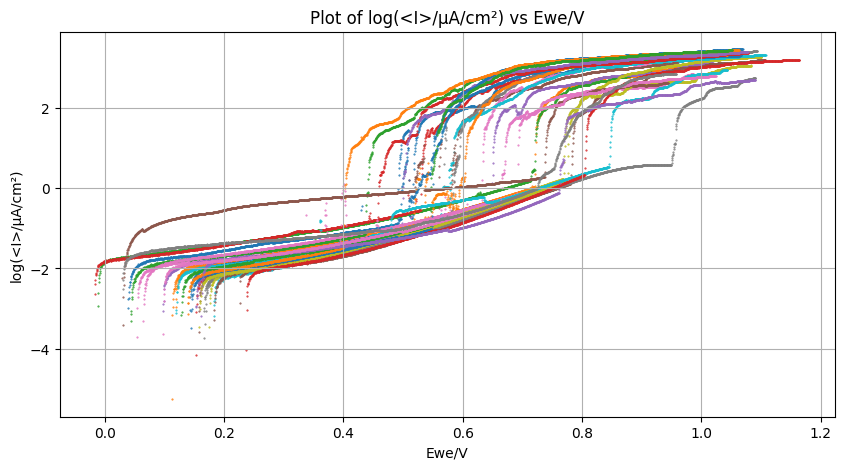

In [420]:
# Placeholder for the area in cm². Please replace 'AREA_IN_CM2' with your actual area value.
AREA_IN_CM2 = 1.0  # Example value
plt.figure(figsize=(10, 5))
# This loop will go through each dataframe in the 'dataframes' list, normalize the current, apply log transform, and plot.
for df in dataframes:
    # Convert the current from mA to µA by multiplying by 1000 (1 mA = 1000 µA).
    df["<I>/µA"] = df["<I>/mA"] * 1000
    
    # Normalize the current to current density (µA/cm²).
    # Assuming the area is in cm². Replace 'AREA_IN_CM2' with the actual area.
    df["<I>/µA/cm²"] = df["<I>/µA"] / AREA_IN_CM2
    
    # Apply the log transformation only to non-zero values of current density.
    # We avoid taking the log of zero or negative values to prevent math errors.
    df["log(<I>/µA/cm²)"] = [np.log10(abs(i)) if i > 0 else np.nan for i in df["<I>/µA/cm²"]]
    
    # Plot the Ewe/V vs. log of current density
    plt.scatter(df["Ewe/V"], df["log(<I>/µA/cm²)"], marker='.', s=1)
    plt.xlabel('Ewe/V')
    plt.ylabel('log(<I>/µA/cm²)')
    plt.title('Plot of log(<I>/µA/cm²) vs Ewe/V')
    plt.grid(True)
plt.show()

In [421]:
# =====================================================
# 4. LOG / E MATRICES + METASTABLE INDICES
# =====================================================

# Build two tables where each column corresponds to one curve
df_concentration_log = pd.DataFrame({
    i: df['log(<I>/µA/cm²)'] for i, df in enumerate(dataframes)
})
df_concentration_E = pd.DataFrame({
    i: df['Ewe/V'] for i, df in enumerate(dataframes)
})

# Metastable indices identified manually (one list per concentration)
meta_indices = {
    "0.005M NaCl": [4, 6, 7, 11, 16, 17, 21, 24, 26],
    "0.01M NaCl": [10, 17, 22, 26],
    "0.05M NaCl": [0, 2, 7, 9, 10, 11, 27]   # 0-based indexing
}

meta_i = meta_indices.get(selected_concentration, [])
print(f"Metastable indices for {selected_concentration}: {meta_i}")
print(
    "Note: curves showing stable pitting growth preceded by metastable activity "
    "were labeled manually."
)


Metastable indices for 0.05M NaCl: [0, 2, 7, 9, 10, 11, 27]
Note: curves showing stable pitting growth preceded by metastable activity were labeled manually.


In [422]:
# Load the CSV files with calculated data
# Note: Make sure these CSV files match the selected NaCl concentration
print(f"Loading calculated data for {selected_concentration}")
print("IMPORTANT: Please verify that the CSV files contain data for the correct NaCl concentration")

# To load the CSV with the index column
calculated_epit_df = pd.read_csv('calculated_epit_data.csv', index_col=0)
print(f"Loaded calculated_epit_data.csv - Verify this contains {selected_concentration} data")

# To load the CSV with the index column
calculated_logipit_df = pd.read_csv('calculated_logipit_data.csv', index_col=0)
print(f"Loaded calculated_logipit_data.csv - Verify this contains {selected_concentration} data")

# To load the CSV with the index column
epass_df = pd.read_csv('calculated_epass_data.csv', index_col=0)
print(f"Loaded calculated_epass_data.csv - Verify this contains {selected_concentration} data")

# Display a preview of the loaded data for verification
print("\nPreview of calculated_epit_df:")
print(calculated_epit_df.head())

Loading calculated data for 0.05M NaCl
IMPORTANT: Please verify that the CSV files contain data for the correct NaCl concentration
Loaded calculated_epit_data.csv - Verify this contains 0.05M NaCl data
Loaded calculated_logipit_data.csv - Verify this contains 0.05M NaCl data
Loaded calculated_epass_data.csv - Verify this contains 0.05M NaCl data

Preview of calculated_epit_df:
   Calculated Epit (V)
0             0.517708
1             0.720248
2             0.719957
3             0.528795
4             0.648144


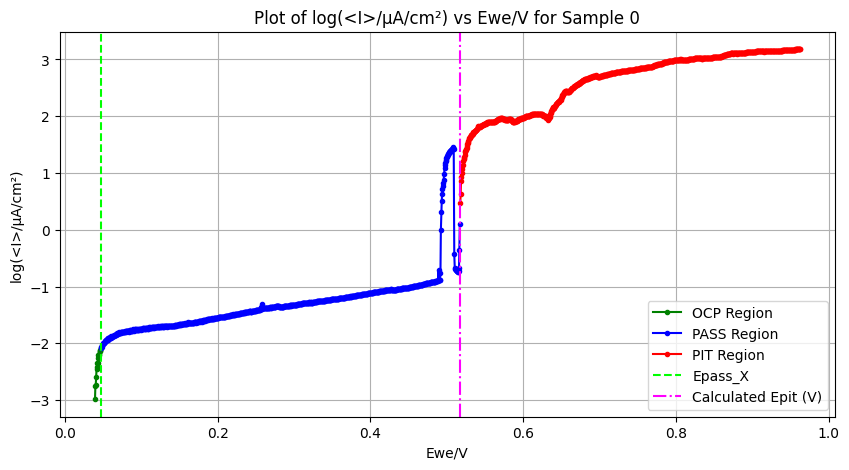

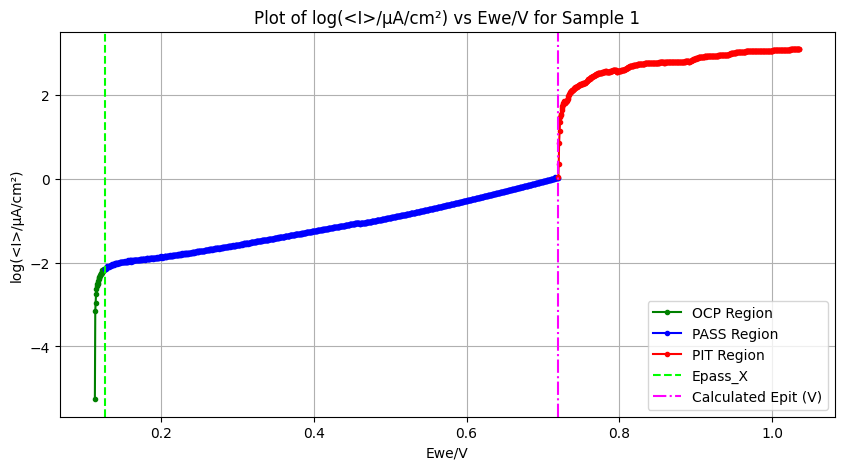

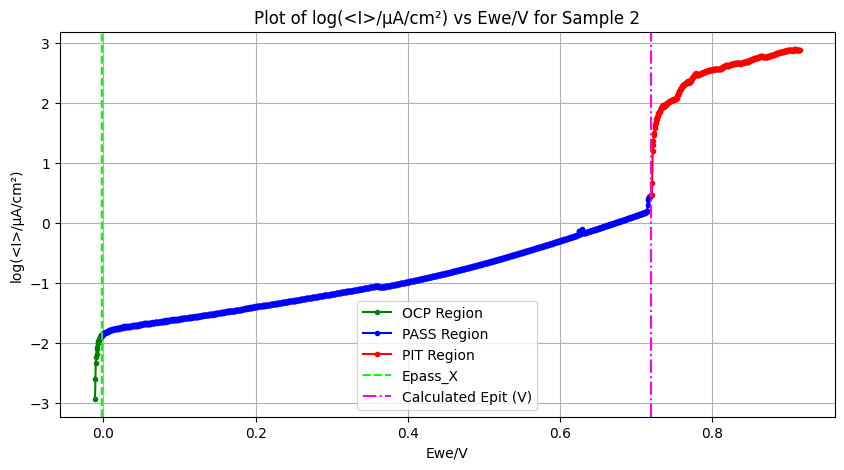

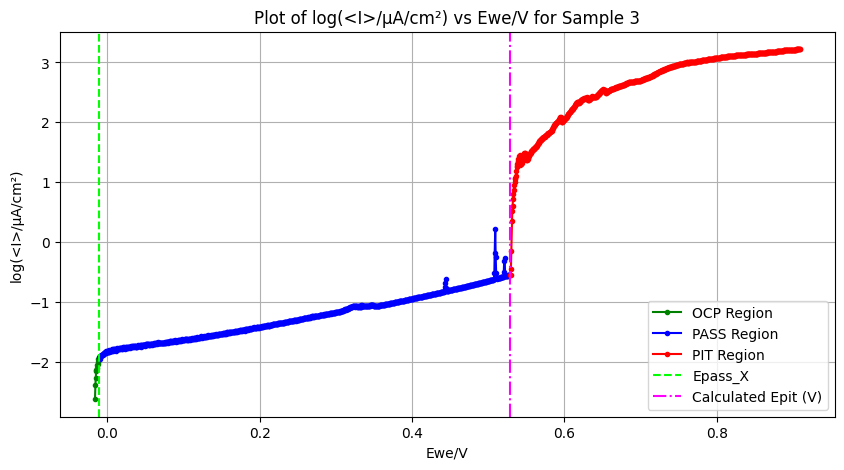

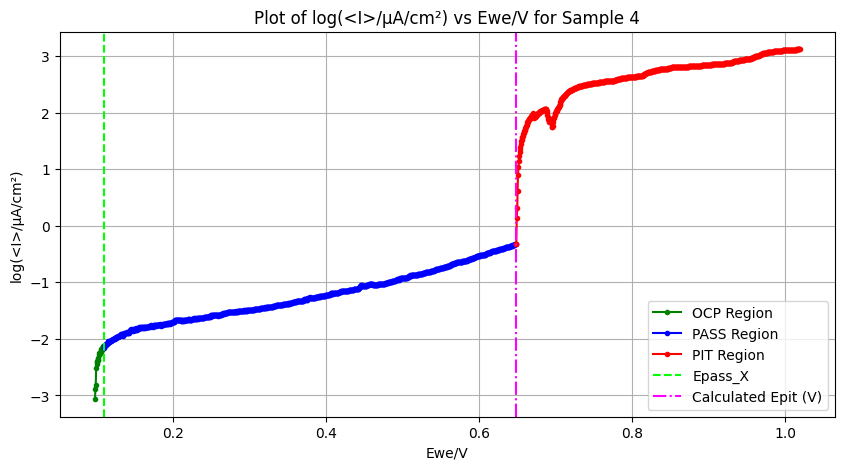

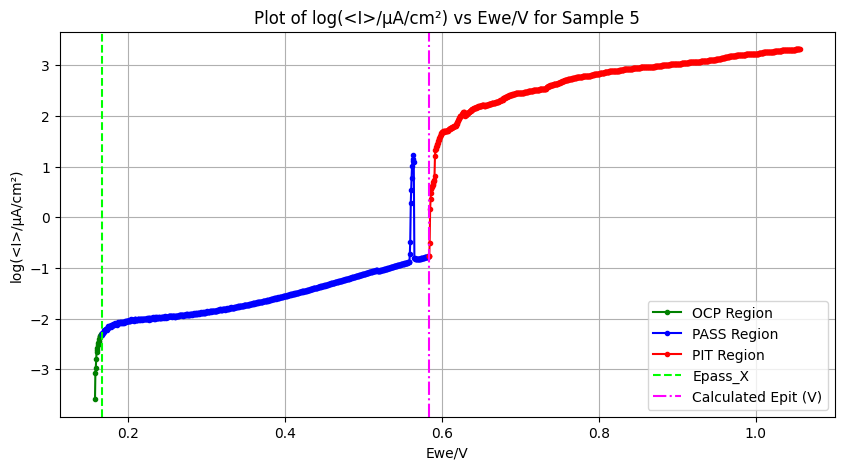

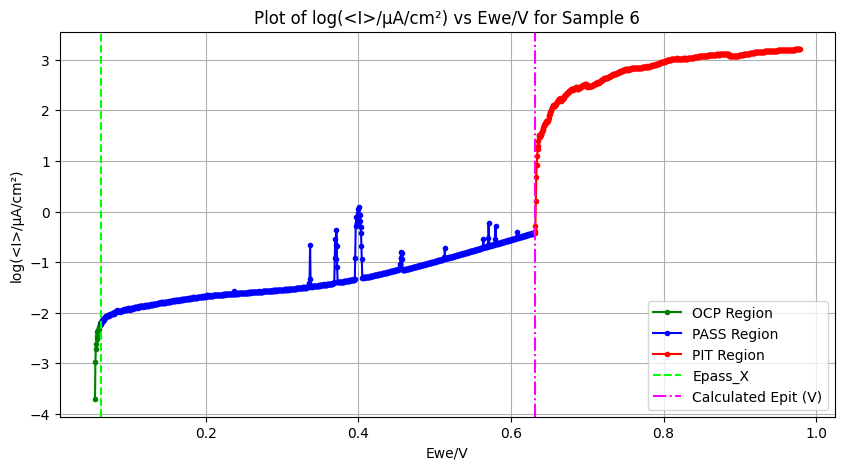

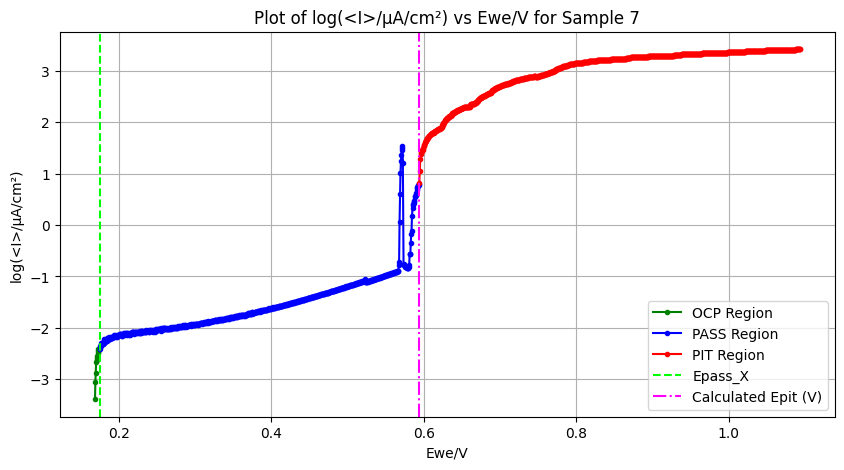

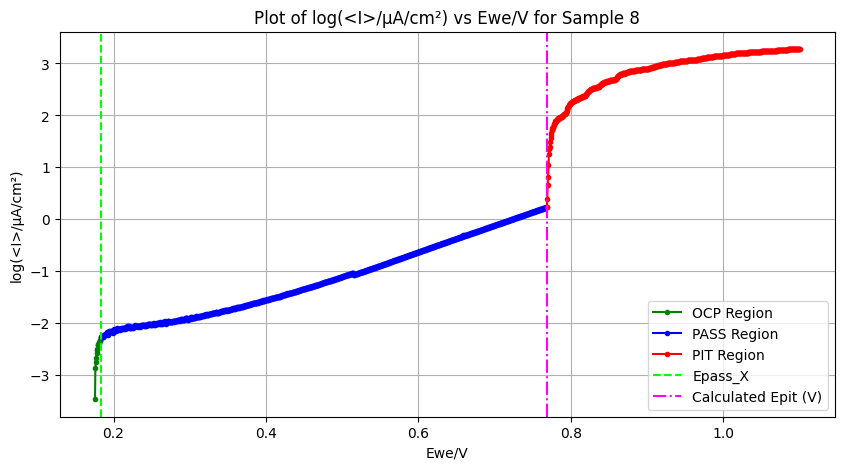

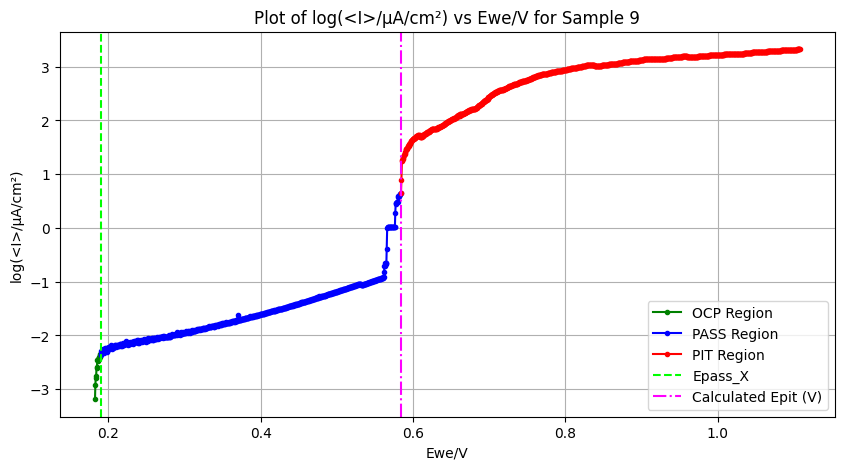

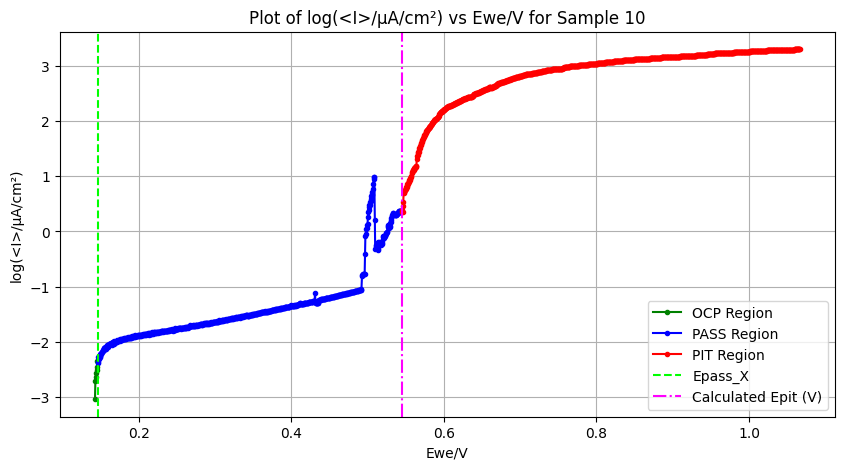

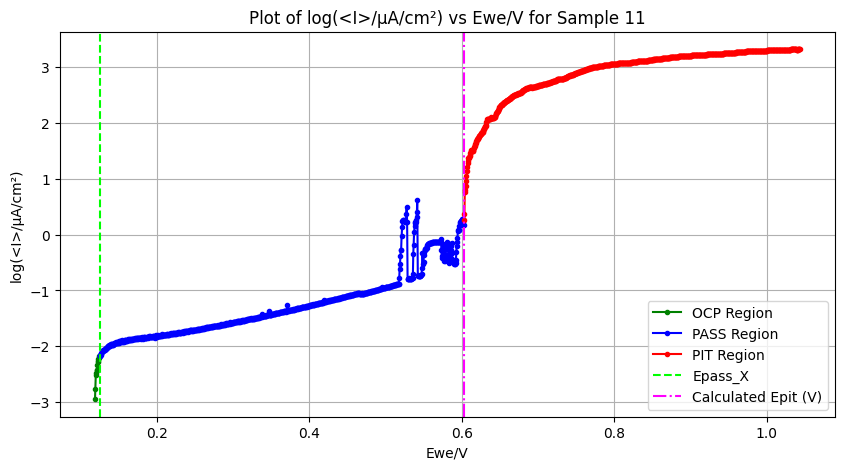

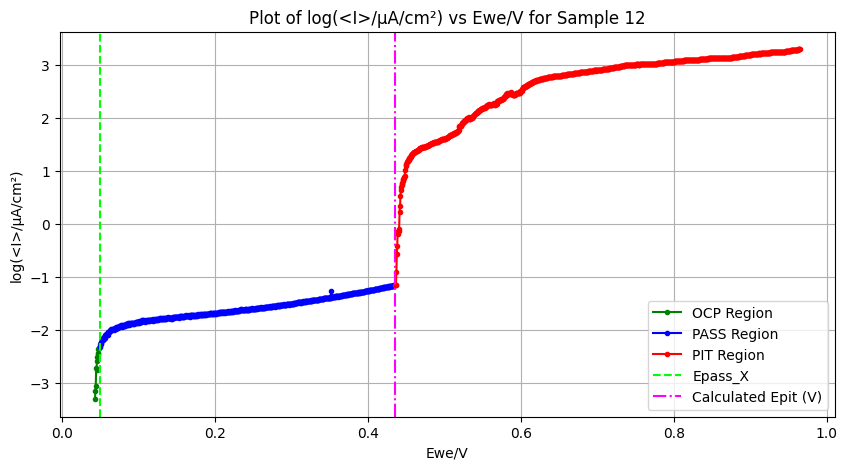

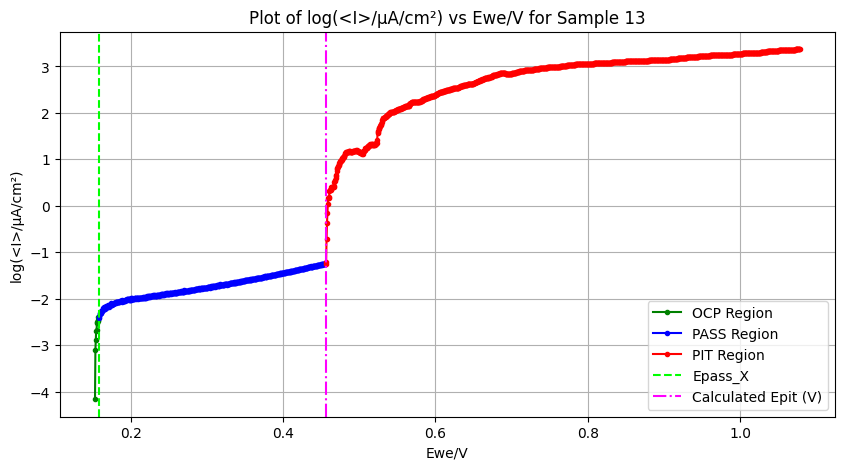

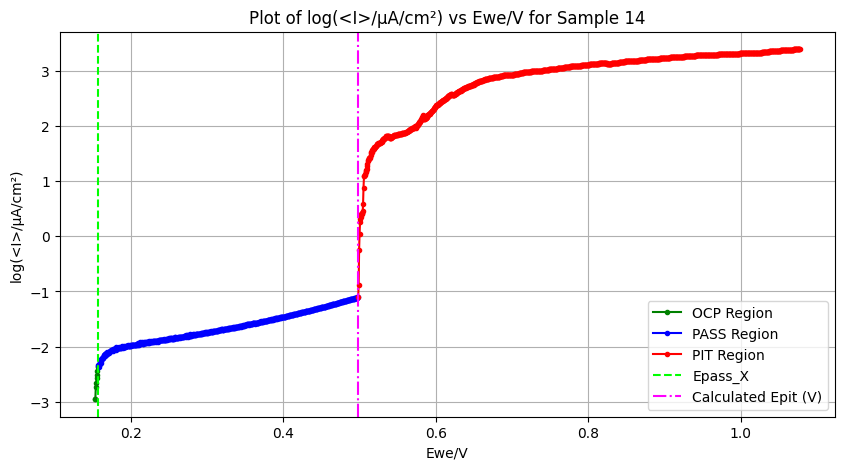

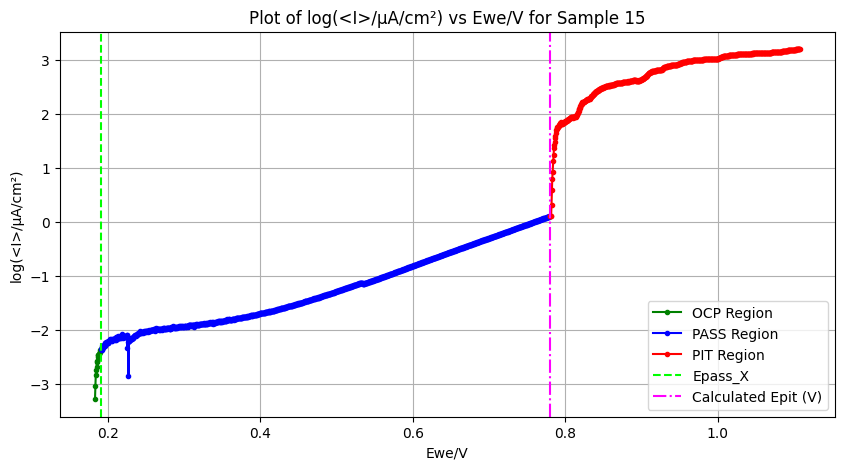

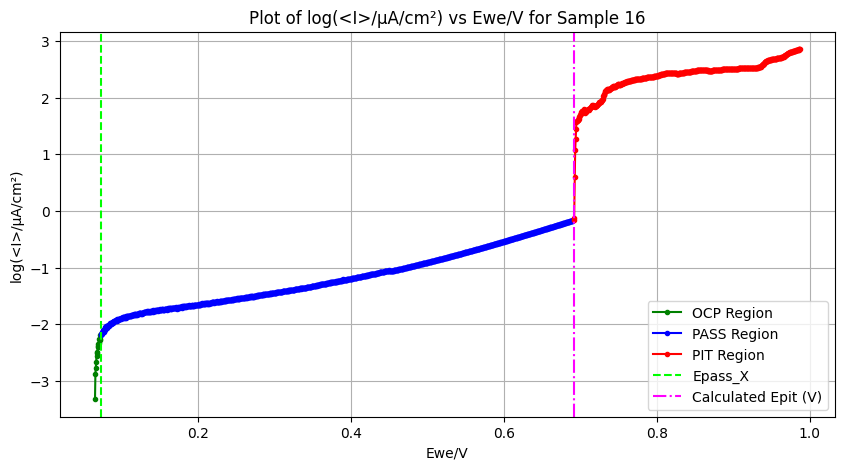

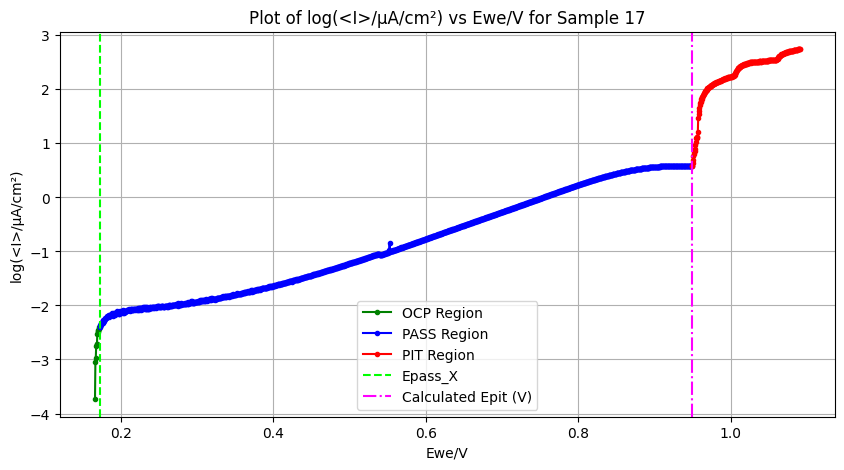

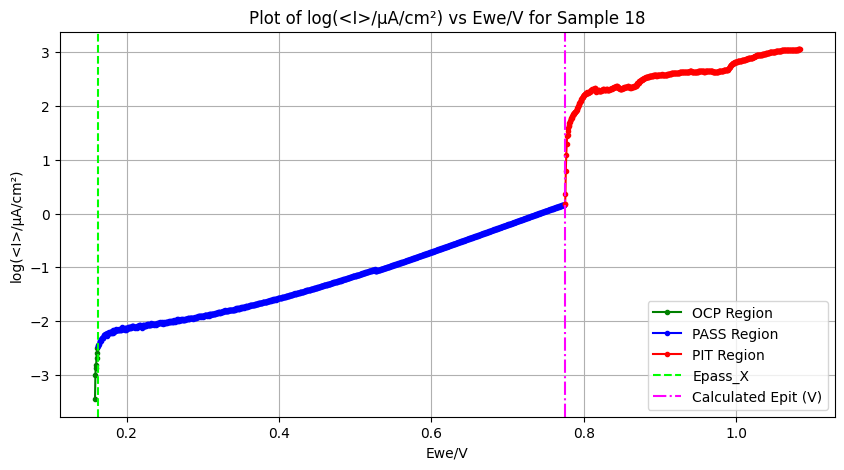

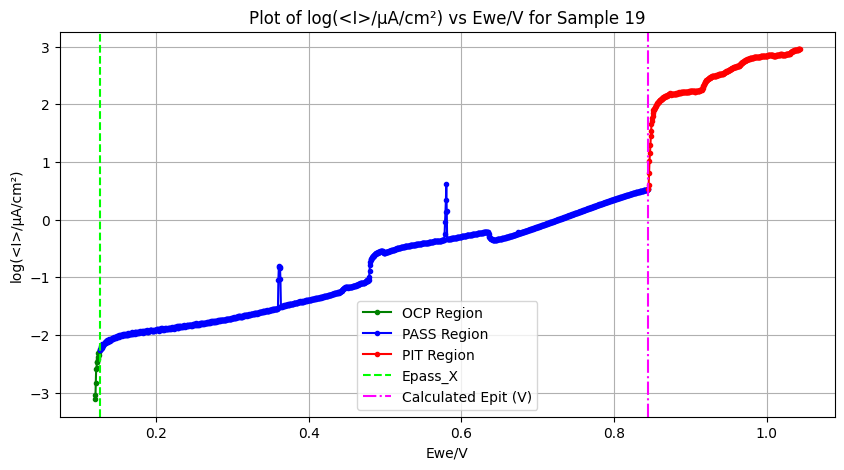

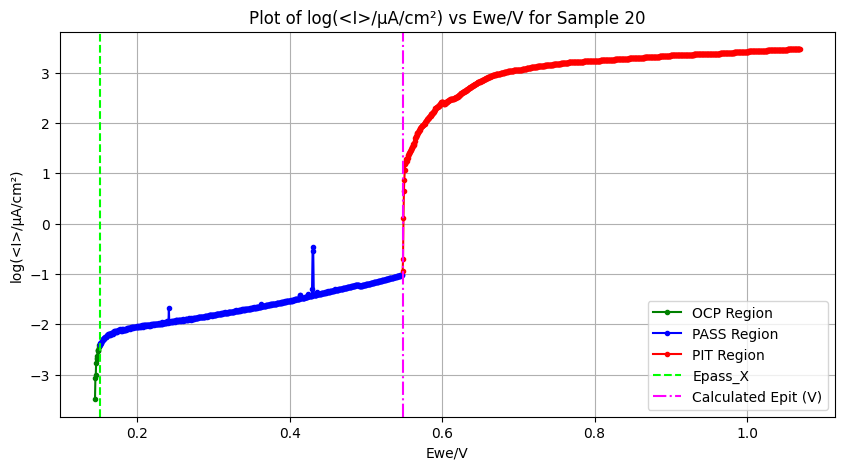

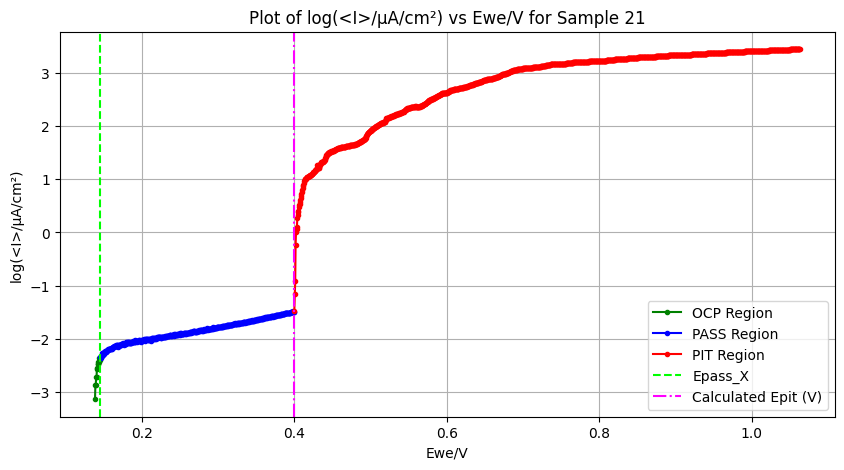

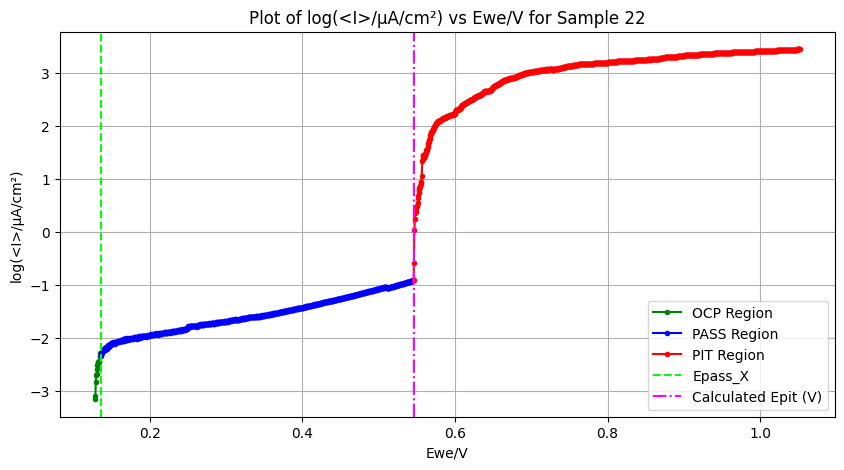

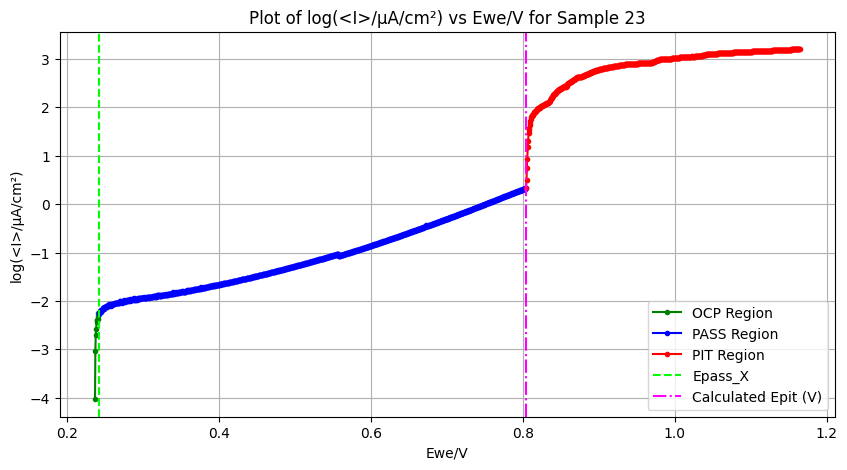

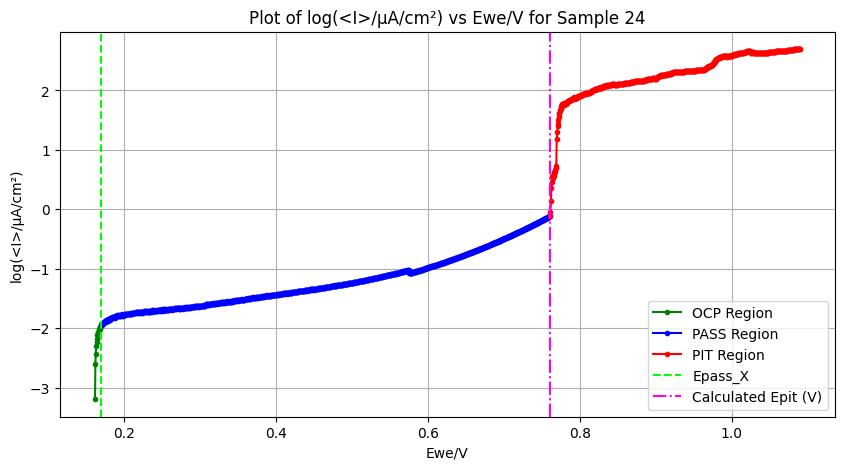

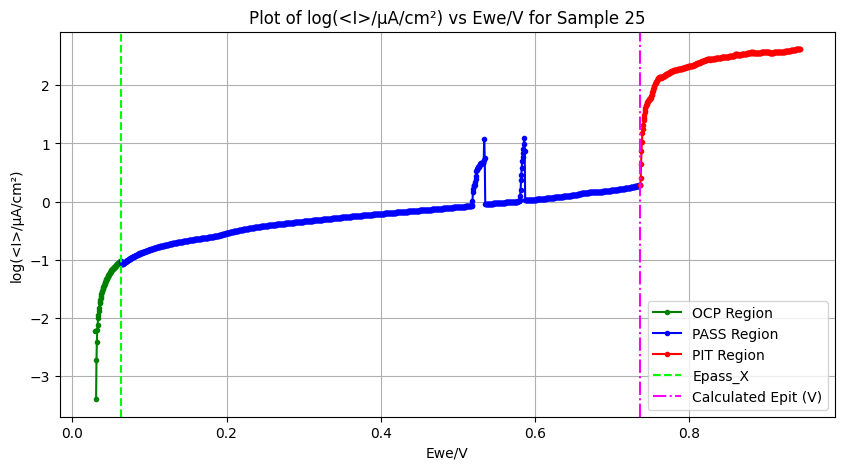

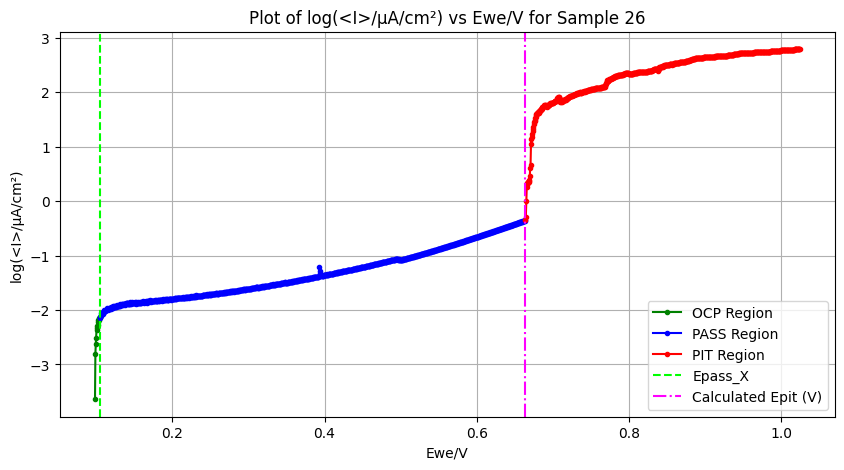

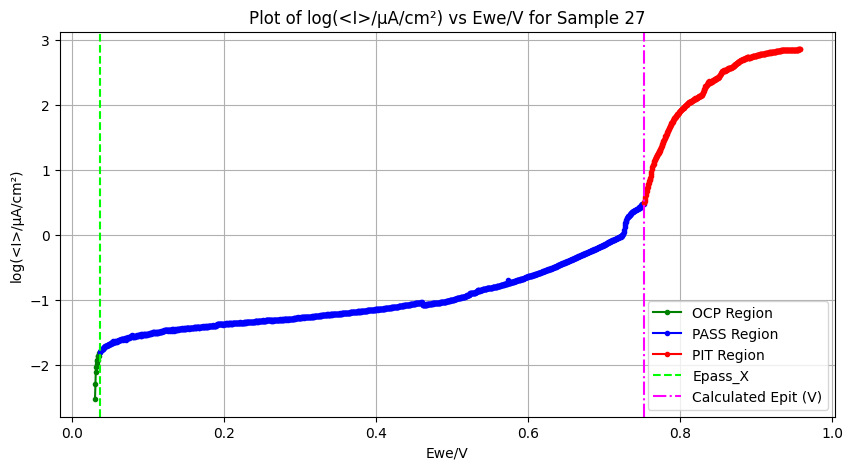

In [423]:
# Initialize dictionaries to hold the filtered data for each region for all samples.
data_ocp_dict = {}
data_pass_dict = {}
data_pit_dict = {}

data_ocp_dict_E = {}
data_pass_dict_E = {}
data_pit_dict_E = {}

# Loop through each sample (column) in the 'df_concentration_log' DataFrame.
for sample in df_concentration_log.columns:
    # Extract the log current and potential values for the current sample.
    log_current_sample = df_concentration_log[sample]
    potential_sample = df_concentration_E[sample]

    # Retrieve 'Epass_X', 'Epit (V)', and 'Calculated Epit (V)' values for the current sample.
    epass_x = epass_df["Epass_X"].loc[sample]
    epit_x = calculated_epit_df.loc[sample]
    calculated_epit_x = calculated_epit_df["Calculated Epit (V)"].loc[sample]

    # Use boolean masking to filter the regions using the calculated Epit.
    ocp_mask = potential_sample < epass_x
    pass_mask = (potential_sample >= epass_x) & (potential_sample < calculated_epit_x)
    pit_mask = potential_sample >= calculated_epit_x

    # Store the filtered data in the corresponding dictionaries.
    data_ocp_dict[sample] = log_current_sample[ocp_mask]
    data_pass_dict[sample] = log_current_sample[pass_mask]
    data_pit_dict[sample] = log_current_sample[pit_mask]
    
    data_ocp_dict_E[sample] = potential_sample[ocp_mask]
    data_pass_dict_E[sample] = potential_sample[pass_mask]
    data_pit_dict_E[sample] = potential_sample[pit_mask]
    
    # (Optional) Plotting the regions for each sample.
    plt.figure(figsize=(10, 5))
    plt.plot(potential_sample[ocp_mask], log_current_sample[ocp_mask], marker='.', color='green', label='OCP Region')
    plt.plot(potential_sample[pass_mask], log_current_sample[pass_mask], marker='.', color='blue', label='PASS Region')
    plt.plot(potential_sample[pit_mask], log_current_sample[pit_mask], marker='.', color='red', label='PIT Region')

    # Add vertical lines for Epass, original Epit, and calculated Epit
    plt.axvline(x=epass_x, color='lime', linestyle='--', label='Epass_X')
    #plt.axvline(x=epit_x, color='red', linestyle='-', label='Original Epit (V)')
    plt.axvline(x=calculated_epit_x, color='magenta', linestyle='-.', label='Calculated Epit (V)')

    plt.xlabel('Ewe/V')
    plt.ylabel('log(<I>/µA/cm²)')
    plt.title(f'Plot of log(<I>/µA/cm²) vs Ewe/V for Sample {sample}')
    plt.legend()
    plt.grid(True)
    #plt.xlim(0.6,0.8)
    plt.show()

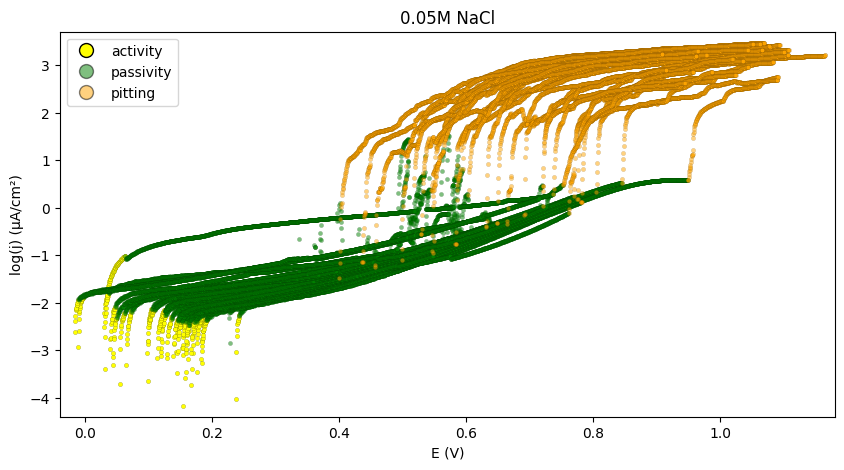

In [424]:
# Convert dictionaries to DataFrames for each region.
data_ocp = pd.DataFrame(data_ocp_dict)
data_pass = pd.DataFrame(data_pass_dict)
data_pit = pd.DataFrame(data_pit_dict)

data_ocp_E = pd.DataFrame(data_ocp_dict_E)
data_pass_E = pd.DataFrame(data_pass_dict_E)
data_pit_E = pd.DataFrame(data_pit_dict_E)

plt.figure(figsize=(10, 5))

# Plot the data points
plt.scatter(data_ocp_E, data_ocp, edgecolors='k', facecolors='yellow', linewidths=0.1, label="activity", s=10)
plt.scatter(data_pass_E, data_pass, edgecolors='k', facecolors='green', linewidths=0.1, label="passivity", alpha=0.5, s=10)
plt.scatter(data_pit_E, data_pit, edgecolors='k', facecolors='orange', linewidths=0.1, label="pitting", alpha=0.5, s=10)

plt.xlim(-0.04, 1.18)
plt.ylim(-4.4, 3.7)
plt.xlabel('E (V)')
plt.ylabel('log(j) (µA/cm²)')
plt.title(selected_concentration)

# Create custom legend entries with increased marker size
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='activity', markerfacecolor='yellow', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='passivity', markerfacecolor='green', markersize=10, markeredgecolor='k', alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='pitting', markerfacecolor='orange', markersize=10, markeredgecolor='k', alpha=0.5)
]

# Create the legend with the custom entries
plt.legend(handles=legend_elements, fontsize=10)

plt.show()

In [425]:
# To load the CSV with the index column
calculated_epit_df_meta = pd.read_csv('calculated_epit_df_meta_data.csv', index_col=0)

# To load the CSV with the index column
calculated_logipit_df_meta = pd.read_csv('calculated_logipit_df_meta_data.csv', index_col=0)

# Flatten the DataFrame to get all data points as a single array
all_data = df_concentration_log.values.flatten()

# Exclude NaN and Inf values for the computation of the limits
valid_data = all_data[~np.isnan(all_data)]

# Now you can safely use min and max of valid_data
data_min = np.nanmin(valid_data)
data_max = np.nanmax(valid_data)

valid_data = valid_data.round(2)

# Initialize an empty list to hold the rounded log(Ipit) values.
valid_Ipit = []

# Loop through each value in calculated_logipit_df and round the log(Ipit) values.
for i in calculated_logipit_df.index:
    # Get the log(Ipit) value from the calculated_logipit_df for the current index.
    log_ipit_value = calculated_logipit_df.loc[i, 'Calculated log(Ipit) (µA/cm²)']

    # Append the rounded log(Ipit) value to the valid_Ipit list.
    valid_Ipit.append(round(log_ipit_value, 2))

# Convert the list to a NumPy array for consistency.
valid_Ipit = np.array(valid_Ipit)

# Display the array to verify the results.
print(valid_Ipit)

[ 0.47  0.04  0.46 -0.55 -0.32 -0.77 -0.42  0.82  0.24  0.66  0.36  0.27
 -1.15 -1.25 -1.1   0.11 -0.16  0.58  0.17  0.53 -0.95 -1.47 -0.91  0.33
 -0.11  0.29 -0.35  0.48]


In [426]:
# Initialize an empty list to hold the rounded log(Ipit) values for the meta DataFrame.
valid_Ipit_meta = []

# Loop through each value in calculated_logipit_df_meta and round the log(Ipit) values.
for i in calculated_logipit_df_meta.index:
    # Get the log(Ipit) value from the calculated_logipit_df_meta for the current index.
    log_ipit_value = calculated_logipit_df_meta.loc[i, 'Calculated log(Ipit) (µA/cm²)']

    # Append the rounded log(Ipit) value to the valid_Ipit_meta list.
    valid_Ipit_meta.append(round(log_ipit_value, 2))

# Convert the list to a NumPy array for consistency.
valid_Ipit_meta = np.array(valid_Ipit_meta)

# Display the array to verify the results.
print(valid_Ipit_meta)

# Initialize empty lists to hold the rounded log(Ipit) values for Epit and Esp.
valid_Ipit_Epit = []
valid_Ipit_Esp = []

# Convert meta_i to a set for faster membership testing
meta_i_set = set(meta_i)

# Loop through each value in calculated_logipit_df and round the log(Ipit) values.
for i in calculated_logipit_df.index:
    # Get the log(Ipit) value from the calculated_logipit_df for the current index.
    log_ipit_value = calculated_logipit_df.loc[i, 'Calculated log(Ipit) (µA/cm²)']
    
    # Round the log(Ipit) value
    rounded_value = round(log_ipit_value, 2)
    
    # Append the rounded log(Ipit) value to the appropriate list
    if i in meta_i_set:
        valid_Ipit_Esp.append(rounded_value)
    else:
        valid_Ipit_Epit.append(rounded_value)

# Convert the lists to NumPy arrays for consistency.
valid_Ipit_Epit = np.array(valid_Ipit_Epit)
valid_Ipit_Esp = np.array(valid_Ipit_Esp)

# Display the arrays to verify the results.
print("valid_Ipit_Epit:", valid_Ipit_Epit)
print("valid_Ipit_Esp:", valid_Ipit_Esp)
print("valid_Ipit (combined):", valid_Ipit)

epit_values_meta = calculated_epit_df_meta["Calculated Epit (V)"].values
valid_meta_epit = [e for e in epit_values_meta if not np.isnan(e)]
valid_meta_ipit = [i for i in valid_Ipit_meta if not np.isnan(i)]

[-0.88   nan  0.17   nan   nan   nan   nan -0.83   nan -0.93 -1.06 -0.52
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan -0.02]
valid_Ipit_Epit: [ 0.04 -0.55 -0.32 -0.77 -0.42  0.24 -1.15 -1.25 -1.1   0.11 -0.16  0.58
  0.17  0.53 -0.95 -1.47 -0.91  0.33 -0.11  0.29 -0.35]
valid_Ipit_Esp: [0.47 0.46 0.82 0.66 0.36 0.27 0.48]
valid_Ipit (combined): [ 0.47  0.04  0.46 -0.55 -0.32 -0.77 -0.42  0.82  0.24  0.66  0.36  0.27
 -1.15 -1.25 -1.1   0.11 -0.16  0.58  0.17  0.53 -0.95 -1.47 -0.91  0.33
 -0.11  0.29 -0.35  0.48]


Correlation coefficient: -0.2163


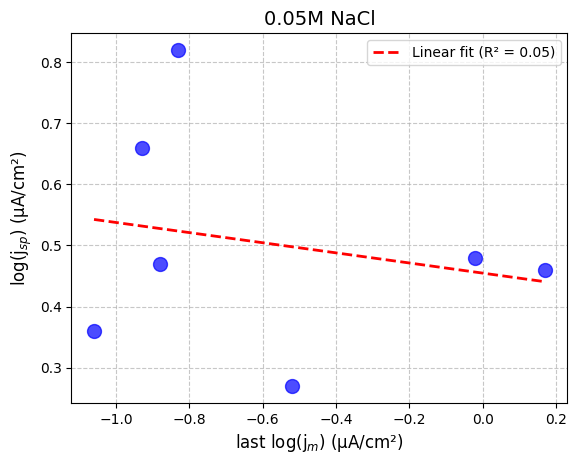

In [427]:
# Extract current values for 'metastable' points (X-axis)
X = [valid_Ipit_meta[i] for i in meta_i]

# Extract current values for 'actual stable pit' points (Y-axis)
Y = [valid_Ipit[i] for i in meta_i]

# Convert lists to numpy arrays for efficient computation
X = np.array(X)
Y = np.array(Y)

# Remove any potential NaN values (should already be handled in meta_indices)
valid_indices = ~np.isnan(X) & ~np.isnan(Y)
X = X[valid_indices]
Y = Y[valid_indices]

# Create the scatter plot
plt.figure()
plt.scatter(X, Y, color='blue', s=100, alpha=0.7, marker='o')

# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(X, Y)[0, 1]
print(f"Correlation coefficient: {correlation_coefficient:.4f}")

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

# Generate a continuous range of x-values for plotting the line
X_range = np.linspace(min(X), max(X), 100)
line = slope * X_range + intercept

# Plot the regression line with a dashed style
plt.plot(X_range, line, color='red', linestyle='--', linewidth=2, label=f"Linear fit (R² = {r_value**2:.2f})")

# Customize the plot
plt.xlabel('last log(j$_{m}$) (µA/cm²)', fontsize=12)
plt.ylabel('log(j$_{sp}$) (µA/cm²)', fontsize=12)
plt.title(f'{selected_concentration}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()

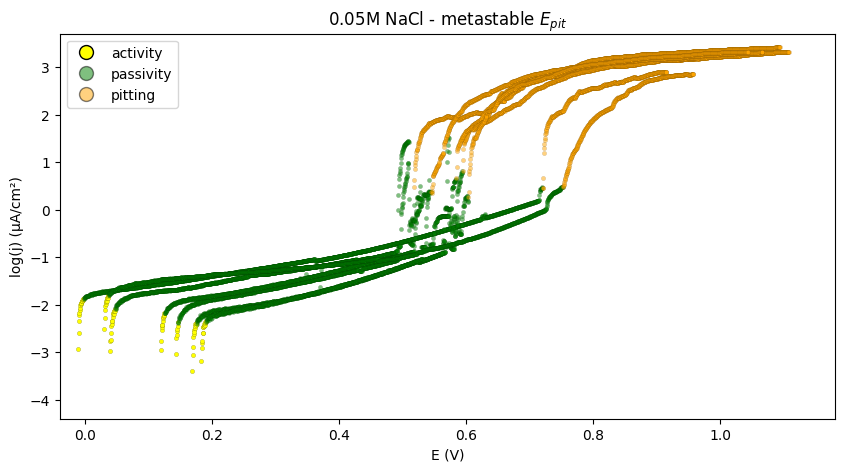

In [428]:
# Convert 'meta_i' to a set for faster lookup
meta_i_set = set(meta_i)

# Filter the data for 'activity' region
filtered_data_ocp_E = [data_ocp_E[i] for i in meta_i]
filtered_data_ocp = [data_ocp[i] for i in meta_i]

# Filter the data for 'passivity' region
filtered_data_pass_E = [data_pass_E[i] for i in meta_i]
filtered_data_pass = [data_pass[i] for i in meta_i]

# Filter the data for 'pitting' region
filtered_data_pit_E = [data_pit_E[i] for i in meta_i]
filtered_data_pit = [data_pit[i] for i in meta_i]

plt.figure(figsize=(10, 5))

# Plot the data points for 'activity'
for idx, (E, j) in enumerate(zip(filtered_data_ocp_E, filtered_data_ocp)):
    plt.scatter(E, j, edgecolors='k', facecolors='yellow', linewidths=0.1, label="activity", s=10)

# Plot the data points for 'passivity'
for idx, (E, j) in enumerate(zip(filtered_data_pass_E, filtered_data_pass)):
    plt.scatter(E, j, edgecolors='k', facecolors='green', linewidths=0.1, label="passivity", alpha=0.5, s=10)

# Plot the data points for 'pitting'
for idx, (E, j) in enumerate(zip(filtered_data_pit_E, filtered_data_pit)):
    plt.scatter(E, j, edgecolors='k', facecolors='orange', linewidths=0.1, label="pitting", alpha=0.5, s=10)

plt.xlim(-0.04, 1.18)
plt.ylim(-4.4, 3.7)
plt.xlabel('E (V)')
plt.ylabel('log(j) (µA/cm²)')
plt.title(selected_concentration+r' - metastable $E_{pit}$')

# Create custom legend entries with increased marker size
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='activity', markerfacecolor='yellow', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='passivity', markerfacecolor='green', markersize=10, markeredgecolor='k', alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='pitting', markerfacecolor='orange', markersize=10, markeredgecolor='k', alpha=0.5)
]

# Create the legend with the custom entries
plt.legend(handles=legend_elements, fontsize=10)

plt.show()

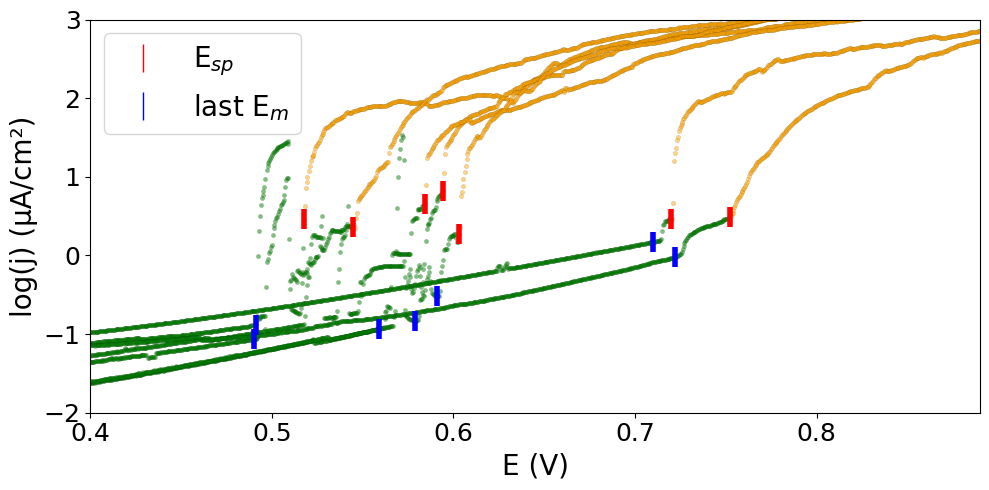

In [429]:
plt.figure(figsize=(10, 5))

# Plot the data points for 'passivity'
for idx, (E, j) in enumerate(zip(filtered_data_pass_E, filtered_data_pass)):
    plt.scatter(E, j, edgecolors='k', facecolors='green', linewidths=0.1, label="passivity", alpha=0.5, s=10)

# Plot the data points for 'pitting'
for idx, (E, j) in enumerate(zip(filtered_data_pit_E, filtered_data_pit)):
    plt.scatter(E, j, edgecolors='k', facecolors='orange', linewidths=0.1, label="pitting", alpha=0.5, s=10)
    plt.scatter(E[E.notna()].iloc[0], j[j.notna()].iloc[0], marker="|", color='red', linewidths=4, s=200, zorder=2)

# Add metastable markers
plt.scatter(valid_meta_epit, valid_meta_ipit, marker="|", color='blue', linewidths=4, s=200, zorder=2)

plt.xlim(0.4, 0.89)
plt.ylim(-2, 3)

# Increase font size for axis labels
plt.xlabel('E (V)', fontsize=20)
plt.ylabel('log(j) (µA/cm²)', fontsize=20)

# Increase tick label sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Create custom legend entries with increased marker size
legend_elements = [
    Line2D([0], [0], marker='|', color='red', label='E$_{sp}$', markersize=20, linewidth=20, linestyle='None'),
    Line2D([0], [0], marker='|', color='blue', label='last E$_{m}$', markersize=20, linewidth=20, linestyle='None')
]

# Create the legend with the custom entries and increased font size
plt.legend(handles=legend_elements, fontsize=20)

# Adjust layout to ensure everything fits
plt.tight_layout()

plt.show()

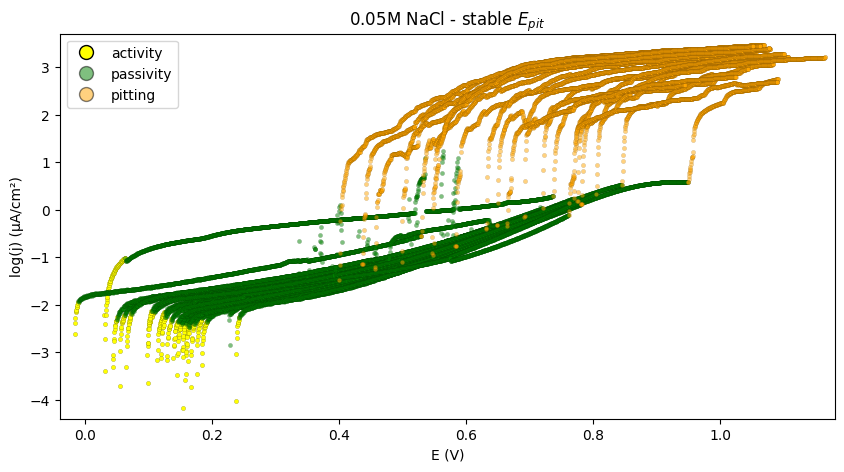

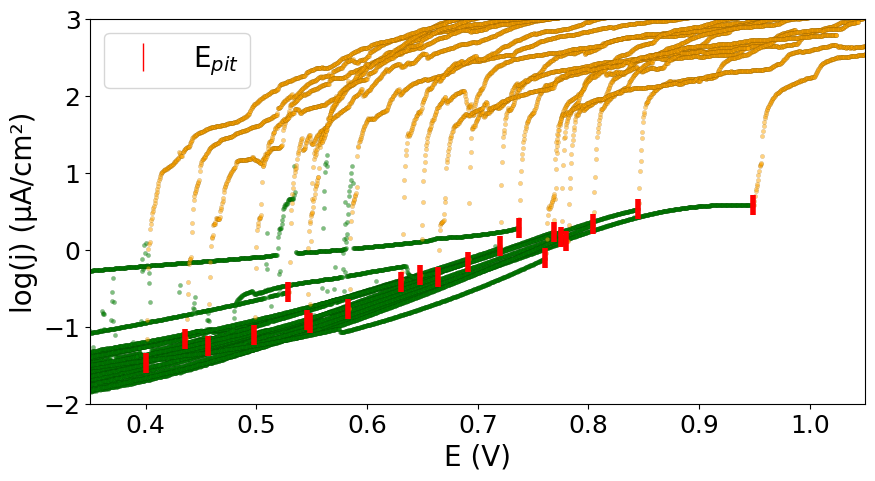

In [430]:

# Total number of curves (assuming all data lists have the same length)
num_curves = len(data_ocp_E.columns)

# Generate a list of all curve indices
all_indices = set(range(num_curves))

# Get the indices of the curves to include (complement of meta_i)
include_indices = all_indices - meta_i_set

# Sort the indices to maintain order
include_indices = sorted(include_indices)

# Filter the data for 'activity' region
filtered_data_ocp_E = [data_ocp_E[i] for i in include_indices]
filtered_data_ocp = [data_ocp[i] for i in include_indices]

# Filter the data for 'passivity' region
filtered_data_pass_E = [data_pass_E[i] for i in include_indices]
filtered_data_pass = [data_pass[i] for i in include_indices]

# Filter the data for 'pitting' region
filtered_data_pit_E = [data_pit_E[i] for i in include_indices]
filtered_data_pit = [data_pit[i] for i in include_indices]

# First plot - Standard view of stable samples
plt.figure(figsize=(10, 5))

# Plot the data points for 'activity'
for idx, (E, j) in enumerate(zip(filtered_data_ocp_E, filtered_data_ocp)):
    plt.scatter(E, j, edgecolors='k', facecolors='yellow', linewidths=0.1, label="activity", s=10)

# Plot the data points for 'passivity'
for idx, (E, j) in enumerate(zip(filtered_data_pass_E, filtered_data_pass)):
    plt.scatter(E, j, edgecolors='k', facecolors='green', linewidths=0.1, label="passivity", alpha=0.5, s=10)

# Plot the data points for 'pitting'
for idx, (E, j) in enumerate(zip(filtered_data_pit_E, filtered_data_pit)):
    plt.scatter(E, j, edgecolors='k', facecolors='orange', linewidths=0.1, label="pitting", alpha=0.5, s=10)

plt.xlim(-0.04, 1.18)
plt.ylim(-4.4, 3.7)
plt.xlabel('E (V)')
plt.ylabel('log(j) (µA/cm²)')
plt.title(selected_concentration+r' - stable $E_{pit}$')

# Create custom legend entries with increased marker size
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='activity', markerfacecolor='yellow', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='passivity', markerfacecolor='green', markersize=10, markeredgecolor='k', alpha=0.5),
    Line2D([0], [0], marker='o', color='w', label='pitting', markerfacecolor='orange', markersize=10, markeredgecolor='k', alpha=0.5)
]

# Create the legend with the custom entries
plt.legend(handles=legend_elements, fontsize=10)

plt.show()

# Second plot - Zoomed view of stable samples
plt.figure(figsize=(10, 5))

# Plot the data points for 'passivity'
for idx, (E, j) in enumerate(zip(filtered_data_pass_E, filtered_data_pass)):
    plt.scatter(E, j, edgecolors='k', facecolors='green', linewidths=0.1, label="passivity", alpha=0.5, s=10)

# Plot the data points for 'pitting'
for idx, (E, j) in enumerate(zip(filtered_data_pit_E, filtered_data_pit)):
    plt.scatter(E, j, edgecolors='k', facecolors='orange', linewidths=0.1, label="pitting", alpha=0.5, s=10)
    plt.scatter(E[E.notna()].iloc[0], j[j.notna()].iloc[0], marker="|", color='red', linewidths=4, s=200, zorder=2)

plt.xlim(0.35, 1.05)
plt.ylim(-2, 3)
plt.xlabel('E (V)', fontsize=20)
plt.ylabel('log(j) (µA/cm²)', fontsize=20)
# Increase tick label sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Create custom legend entries with increased marker size
legend_elements = [
    Line2D([0], [0], marker='|', color='red', label='E$_{pit}$', markersize=20, linewidth=20, linestyle='None'),
]

# Create the legend with the custom entries
plt.legend(handles=legend_elements, fontsize=20)

plt.show()

In [431]:
potential_data = df_concentration_E.values.flatten()
valid_potential_data = potential_data[~np.isnan(all_data)]

# Calculate frequencies
values, counts = np.unique(valid_data, return_counts=True)

# Get the corresponding potentials for the ordered values
value_to_indices = {value: np.where(valid_data == value)[0] for value in values}
corresponding_potentials = [np.mean(valid_potential_data[indices]) for indices in value_to_indices.values()]

global_min_j, global_max_j = values.min()-0.05*values.min(), values.max()+0.05*values.max()

# Normalize counts to range from 0 to 1
global_normalisation_factor = np.max(counts) - np.min(counts)
normalized_counts = (counts - np.min(counts)) / global_normalisation_factor

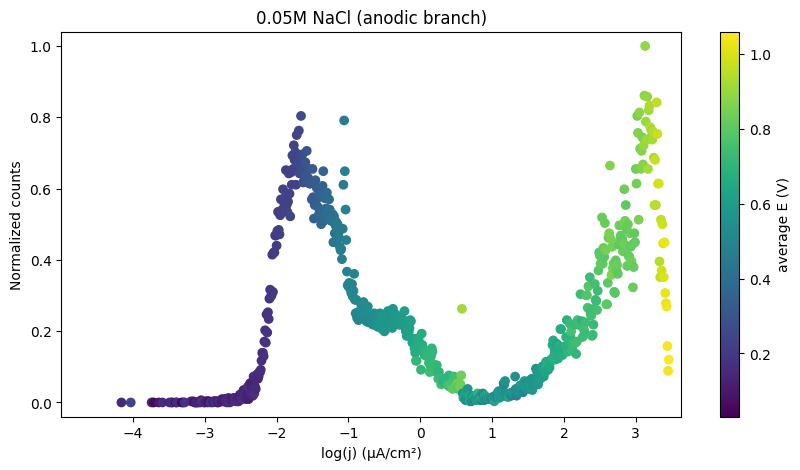

In [432]:
# Plot "number of counts vs values" with colormap based on potential
plt.figure(figsize=(10, 5))
scatter = plt.scatter(values, normalized_counts, c=corresponding_potentials, cmap='viridis')
plt.colorbar(scatter, label='average E (V)')
plt.xlabel('log(j) (µA/cm²)')
plt.ylabel('Normalized counts')

plt.xlim(global_min_j, global_max_j)
plt.ylim(-0.04, 1.04) # normalised
plt.title(selected_concentration +' (anodic branch)')
plt.show()

In [433]:
# Rank the counts in descending order (most frequent first)
unique_counts_descending = np.flip(np.unique(counts))

# Create a dictionary to map counts to ranks
count_to_rank = {count: rank for rank, count in enumerate(unique_counts_descending, start=1)}

# Map the filtered counts to their ranks
ranked_counts = np.array([count_to_rank[count] for count in counts])

# Normalize the counts so that the sum equals  (turning it into a probability density)
normalized_counts = counts / counts.sum()

# Calculate mean potentials
mean_potentials = np.empty_like(ranked_counts, dtype=float)
value_to_indices = {value: np.where(valid_data == value)[0] for value in values}

for unique_count in np.unique(counts):
    all_indices = np.where(counts == unique_count)[0]
    potentials_for_this_count = [valid_potential_data[value_to_indices[values[index]]] for index in all_indices]
    flat_potentials = np.concatenate(potentials_for_this_count)
    mean_potential = np.mean(flat_potentials) if flat_potentials.size > 0 else np.nan
    mean_potentials[all_indices] = mean_potential

# Find the indices of valid_Ipit_Epit and valid_Ipit_Esp in values
ipit_indices_Epit = np.array([np.where(values == ipit)[0][0] for ipit in valid_Ipit_Epit if ipit in values])
ipit_indices_Esp = np.array([np.where(values == ipit)[0][0] for ipit in valid_Ipit_Esp if ipit in values])

# Get the corresponding ranked counts and normalized counts for Epit and Esp
valid_Ipit_Epit_ranked = ranked_counts[ipit_indices_Epit]
valid_Ipit_Epit_normalized = normalized_counts[ipit_indices_Epit]
valid_Ipit_Esp_ranked = ranked_counts[ipit_indices_Esp]
valid_Ipit_Esp_normalized = normalized_counts[ipit_indices_Esp]

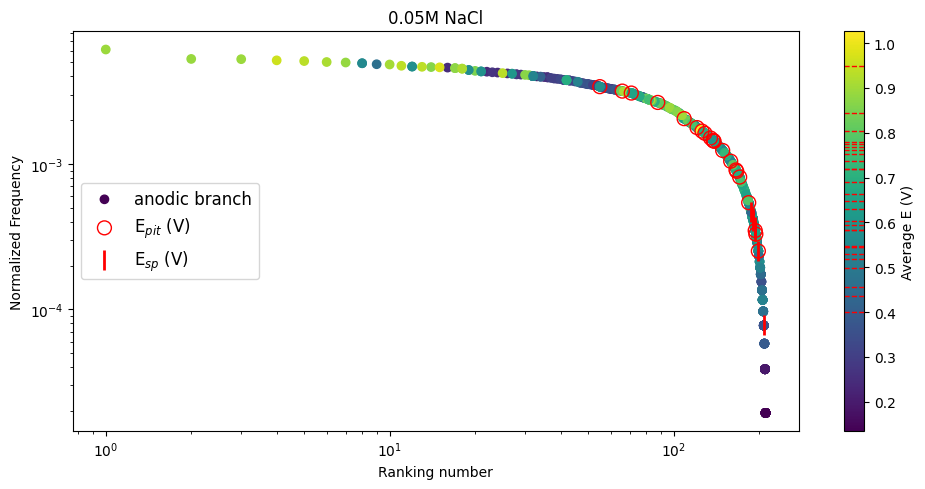

In [434]:
# Create the main scatter plot with the viridis colormap
plt.figure(figsize=(10, 5))
scatter = plt.scatter(ranked_counts, normalized_counts, c=mean_potentials, cmap='viridis', label='anodic branch')
cbar = plt.colorbar(scatter, label='Average E (V)')

# Highlight calculated Epit points
plt.scatter(valid_Ipit_Epit_ranked, valid_Ipit_Epit_normalized, 
            color='none', edgecolor='red', s=100, linewidth=1, label='E$_{pit}$ (V)', zorder=5)

# Highlight calculated Esp points
plt.scatter(valid_Ipit_Esp_ranked, valid_Ipit_Esp_normalized, marker="|",
            color='red', s=200, linewidth=2, label='E$_{sp}$ (V)', zorder=5)

# Add red lines to the colorbar for calculated Epit values
epit_values = calculated_epit_df["Calculated Epit (V)"].values
for epit in epit_values:
    cbar.ax.axhline(epit, color='red', linewidth=1, linestyle='--')

plt.xlabel('Ranking number')
plt.ylabel('Normalized Frequency')
plt.title(selected_concentration)
plt.legend(fontsize=12,loc="center left")
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [435]:
# Print some statistics
print(f"Calculated Epit values: {epit_values}")
print(f"Number of highlighted Epit points: {len(valid_Ipit_Epit_ranked)}")
print(f"Number of highlighted Esp points: {len(valid_Ipit_Esp_ranked)}")
print(f"Rank range of Epit points: {np.min(valid_Ipit_Epit_ranked)} - {np.max(valid_Ipit_Epit_ranked)}")
print(f"Rank range of Esp points: {np.min(valid_Ipit_Esp_ranked)} - {np.max(valid_Ipit_Esp_ranked)}")

# Check the conversion for Epit
print("\nChecking conversion to ranked data for Epit:")
for original, ranked, normalized in zip(valid_Ipit_Epit, valid_Ipit_Epit_ranked, valid_Ipit_Epit_normalized):
    original_count = counts[np.where(values == original)[0][0]]
    print(f"Original value: {original}, Rank: {ranked}, Normalized frequency: {normalized:.6f}, Original count: {original_count}")

# Check the conversion for Esp
print("\nChecking conversion to ranked data for Esp:")
for original, ranked, normalized in zip(valid_Ipit_Esp, valid_Ipit_Esp_ranked, valid_Ipit_Esp_normalized):
    original_count = counts[np.where(values == original)[0][0]]
    print(f"Original value: {original}, Rank: {ranked}, Normalized frequency: {normalized:.6f}, Original count: {original_count}")

Calculated Epit values: [0.5177083  0.72024763 0.71995735 0.52879471 0.64814419 0.58281231
 0.63089043 0.59420407 0.76875037 0.58424163 0.54482311 0.6030677
 0.43580511 0.45610645 0.4981541  0.7799471  0.69113868 0.9489246
 0.77475291 0.84494591 0.54821819 0.40020582 0.5458771  0.80444092
 0.76092196 0.73702997 0.66382402 0.75220776]
Number of highlighted Epit points: 21
Number of highlighted Esp points: 7
Rank range of Epit points: 55 - 199
Rank range of Esp points: 188 - 208

Checking conversion to ranked data for Epit:
Original value: 0.04, Rank: 166, Normalized frequency: 0.000910, Original count: 47
Original value: -0.55, Rank: 139, Normalized frequency: 0.001432, Original count: 74
Original value: -0.32, Rank: 138, Normalized frequency: 0.001451, Original count: 75
Original value: -0.77, Rank: 126, Normalized frequency: 0.001684, Original count: 87
Original value: -0.42, Rank: 135, Normalized frequency: 0.001509, Original count: 78
Original value: 0.24, Rank: 184, Normalized freq

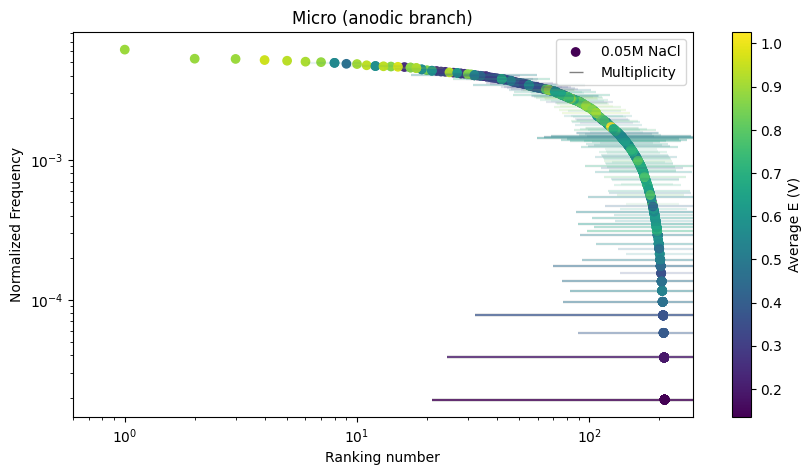

In [436]:
plt.figure(figsize=(10, 5))
scatter = plt.scatter(ranked_counts, normalized_counts, c=mean_potentials, cmap='viridis', label=selected_concentration)
plt.colorbar(scatter, label='Average E (V)')
plt.xlabel('Ranking number')
plt.ylabel('Normalized Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('Micro (anodic branch)')

# We will use this to check if the multiplicity label has already been added
multiplicity_label_added = False

# The ratio m determines how much we extend the bar from the rank on a log scale
m = 1  # Small ratio for the multiplicity bar length

# Calculate the multiplicity of each rank ahead of the loop
unique_ranks, rank_multiplicity = np.unique(ranked_counts, return_counts=True)
multiplicity_dict = dict(zip(unique_ranks, rank_multiplicity))

# Determine the maximum multiplicity for scaling purposes
max_multiplicity = np.max(list(multiplicity_dict.values()))

# Normalize the average ranked_potentials to the colormap's scale
norm = plt.Normalize(min(mean_potentials), max(mean_potentials))
cmap = plt.get_cmap('viridis')

# Create horizontal bars for multiplicity on a log scale
for rank, count, potential in zip(ranked_counts, normalized_counts, mean_potentials):
    multiplicity = multiplicity_dict[rank]
    if multiplicity > 1:
        # Scale multiplicity to be between a minimum length value and 1
        multiplicity_scale = 0.05 + 0.95 * (multiplicity / max_multiplicity)
        
        # Calculate bar length, incorporating both log scale and multiplicity
        bar_length = m * multiplicity_scale
        bar_start = rank / (10 ** bar_length)
        bar_end = rank * (10 ** bar_length)

        # Map the potential to the colormap
        color = cmap(norm(potential))
        # Add the multiplicity line with label only once
        if not multiplicity_label_added:
            plt.hlines(y=count, xmin=bar_start, xmax=bar_end, color=color, alpha=0.05)
            multiplicity_label_added = True
        else:
            plt.hlines(y=count, xmin=bar_start, xmax=bar_end, color=color, alpha=0.05)

# Create a custom legend handle
multiplicity_handle = mlines.Line2D([], [], color='gray', marker='_', linestyle='None',
                                    markersize=10, label='Multiplicity')

# Get the handles and labels from the current axes
handles, labels = plt.gca().get_legend_handles_labels()
# Add custom handle to the list of existing handles
handles.append(multiplicity_handle)

# Set legend once, outside the loop, with the custom handle
plt.legend(handles=handles)

plt.show()

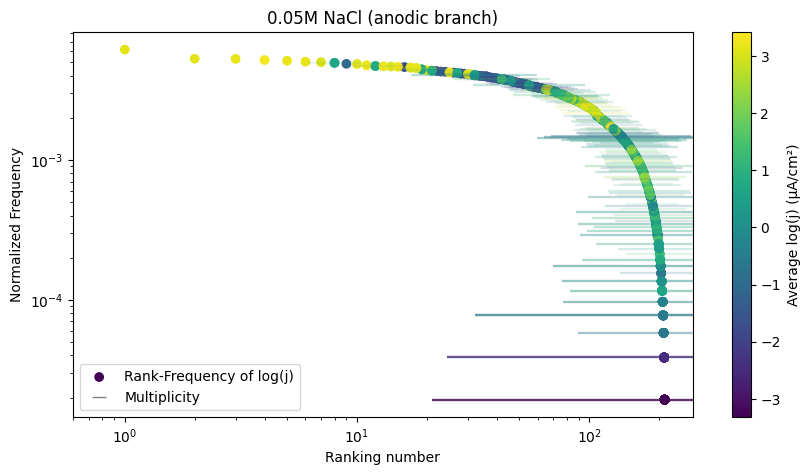

In [437]:
mean_js = np.empty_like(ranked_counts, dtype=float)

for unique_count in np.unique(counts):
    # Get all indices where the count matches the unique count
    all_indices = np.where(counts == unique_count)[0]

    # Retrieve the potential values for these indices
    js_for_this_count = [valid_data[value_to_indices[values[index]]] for index in all_indices]

    # Flatten the list of potential values
    flat_js = np.concatenate(js_for_this_count)

    # Calculate the average potential for this count
    mean_j = np.mean(flat_js) if flat_js.size > 0 else np.nan

    # Instead of extending ranked_potentials, assign the mean potential to the appropriate indices in mean_potentials
    mean_js[all_indices] = mean_j

plt.figure(figsize=(10, 5))
scatter = plt.scatter(ranked_counts, normalized_counts, c=mean_js, cmap="viridis", label='Rank-Frequency of log(j)')
plt.colorbar(scatter, label='Average log(j) (µA/cm²)')
plt.xlabel('Ranking number')
plt.ylabel('Normalized Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title(selected_concentration+' (anodic branch)')

# We will use this to check if the multiplicity label has already been added
multiplicity_label_added = False

# The ratio m determines how much we extend the bar from the rank on a log scale
m = 1  # Small ratio for the multiplicity bar length

# Calculate the multiplicity of each rank ahead of the loop
unique_ranks, rank_multiplicity = np.unique(ranked_counts, return_counts=True)
multiplicity_dict = dict(zip(unique_ranks, rank_multiplicity))

# Determine the maximum multiplicity for scaling purposes
max_multiplicity = np.max(list(multiplicity_dict.values()))

# Normalize the average ranked_potentials to the colormap's scale
norm = plt.Normalize(min(mean_js), max(mean_js))
cmap = plt.get_cmap("viridis")

# Create horizontal bars for multiplicity on a log scale
for rank, count, j in zip(ranked_counts, normalized_counts, mean_js):
    multiplicity = multiplicity_dict[rank]
    if multiplicity > 1:
        # Scale multiplicity to be between a minimum length value and 1
        multiplicity_scale = 0.05 + 0.95 * (multiplicity / max_multiplicity)
        
        # Calculate bar length, incorporating both log scale and multiplicity
        bar_length = m * multiplicity_scale
        bar_start = rank / (10 ** bar_length)
        bar_end = rank * (10 ** bar_length)

        # Map the potential to the colormap
        color = cmap(norm(j))
        # Add the multiplicity line with label only once
        if not multiplicity_label_added:
            plt.hlines(y=count, xmin=bar_start, xmax=bar_end, color=color, alpha=0.05)
            multiplicity_label_added = True
        else:
            plt.hlines(y=count, xmin=bar_start, xmax=bar_end, color=color, alpha=0.05)

# Create a custom legend handle
multiplicity_handle = mlines.Line2D([], [], color='gray', marker='_', linestyle='None',
                                    markersize=10, label='Multiplicity')

# Get the handles and labels from the current axes
handles, labels = plt.gca().get_legend_handles_labels()
# Add custom handle to the list of existing handles
handles.append(multiplicity_handle)

# Set legend once, outside the loop, with the custom handle
plt.legend(handles=handles)

plt.show()

In [438]:
# Import necessary library for PCA
from sklearn.decomposition import PCA

# Combine your data into a single 2D array for PCA
X = np.stack((ranked_counts, normalized_counts), axis=-1)

# Initialize PCA and fit it to your data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# If needed, flip the sign of the first principal component
X_pca[:, 0] *= -1  # This negates the first principal component to reflect the axis

# Print information about the explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"PCA components: {pca.components_}")

Explained variance ratio: [1.00000000e+00 3.93644136e-12]
PCA components: [[ 1.00000000e+00 -2.26335911e-05]
 [ 2.26335911e-05  1.00000000e+00]]


Using PCA boundaries for 0.05M NaCl: [-30, 33, 89, 133]


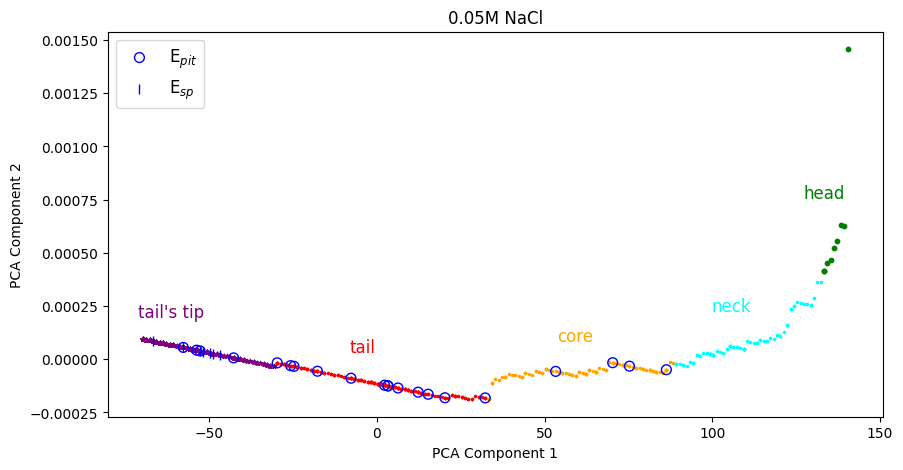

Number of Epit points: 21
Number of Esp points: 7

Distribution of Epit points across clusters:
tail's tip: 4
tail: 13
core: 4
neck: 0
head: 0

Distribution of Esp points across clusters:
tail's tip: 7
tail: 0
core: 0
neck: 0
head: 0

Epit - Median frequency: 1.451379e-03, MAD frequency: 5.611998e-04
Esp - Median frequency: 3.676826e-04, MAD frequency: 5.805515e-05


In [439]:
# Define different PCA boundaries for each concentration
PCA_BOUNDARIES = {
    "0.005M NaCl": [-58, -3, 85, 119],
    "0.01M NaCl": [-51, 45, 104, 127],
    "0.05M NaCl": [-30,33,89,133]  
}

# Define function for custom cluster assignment based on boundaries
def assign_clusters_based_on_boundaries(X_pca, boundaries):
    # Assuming boundaries are sorted in ascending order
    clusters = np.zeros(X_pca.shape[0], dtype=int)
    
    for i, x in enumerate(X_pca[:, 0]):  # Loop over the first PCA component
        for j, boundary in enumerate(boundaries):
            if x <= boundary:
                clusters[i] = j
                break
        else:
            # If the point is beyond the last boundary, assign to the last cluster
            clusters[i] = len(boundaries)
    
    return clusters

# Use the appropriate boundaries based on selected concentration
boundaries = PCA_BOUNDARIES[selected_concentration]
print(f"Using PCA boundaries for {selected_concentration}: {boundaries}")

# Assign clusters
clusters = assign_clusters_based_on_boundaries(X_pca, boundaries)

# Define your labels manually here
labels = ["tail's tip", 'tail', 'core', 'neck', 'head']

# Define colors and markers for each cluster
colors = ['purple', 'red', 'orange', 'cyan', 'green']
markers = ['*', '.', ".", '.', 'o']

# Plotting the PCA components without assigning labels
plt.figure(figsize=(10, 5))

# Plot each cluster
for cluster_id in np.unique(clusters):
    cluster_points = X_pca[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_id],
                marker=markers[cluster_id], s=10)
    
    # Annotate each cluster with its label
    mean_position = cluster_points.mean(axis=0)
    
    offset_x = -3
    offset_y = np.ptp(X_pca[:, 1]) * 0.1
    
    plt.text(mean_position[0] + offset_x, mean_position[1] + offset_y, labels[cluster_id],
             horizontalalignment='center', verticalalignment='center',
             fontsize=12, color=colors[cluster_id])

# Add highlighted Epit points
highlighted_pca_epit = X_pca[ipit_indices_Epit]
plt.scatter(highlighted_pca_epit[:, 0], highlighted_pca_epit[:, 1], facecolors='none', edgecolors='blue', 
            linewidths=1, s=50, label='E$_{pit}$', zorder=5)

# Add highlighted Esp points
highlighted_pca_esp = X_pca[ipit_indices_Esp]
plt.scatter(highlighted_pca_esp[:, 0], highlighted_pca_esp[:, 1], facecolors='blue', marker="|",
            linewidths=1, s=50, label='E$_{sp}$', zorder=5)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f"{selected_concentration}")
plt.legend(fontsize=12)
plt.show()

# Calculate median and MAD of highlighted frequencies for Epit and Esp
highlighted_freqs_epit = normalized_counts[ipit_indices_Epit]
highlighted_freqs_esp = normalized_counts[ipit_indices_Esp]
median_freq_epit = np.median(highlighted_freqs_epit)
mad_freq_epit = np.median(np.abs(highlighted_freqs_epit - median_freq_epit))
median_freq_esp = np.median(highlighted_freqs_esp)
mad_freq_esp = np.median(np.abs(highlighted_freqs_esp - median_freq_esp))

print(f"Number of Epit points: {len(ipit_indices_Epit)}")
print(f"Number of Esp points: {len(ipit_indices_Esp)}")

# Calculate the distribution of Epit and Esp points across clusters
epit_cluster_distribution = [np.sum(clusters[ipit_indices_Epit] == cluster_id) for cluster_id in range(len(labels))]
esp_cluster_distribution = [np.sum(clusters[ipit_indices_Esp] == cluster_id) for cluster_id in range(len(labels))]

print("\nDistribution of Epit points across clusters:")
for label, count in zip(labels, epit_cluster_distribution):
    print(f"{label}: {count}")

print("\nDistribution of Esp points across clusters:")
for label, count in zip(labels, esp_cluster_distribution):
    print(f"{label}: {count}")

print(f"\nEpit - Median frequency: {median_freq_epit:.6e}, MAD frequency: {mad_freq_epit:.6e}")
print(f"Esp - Median frequency: {median_freq_esp:.6e}, MAD frequency: {mad_freq_esp:.6e}")

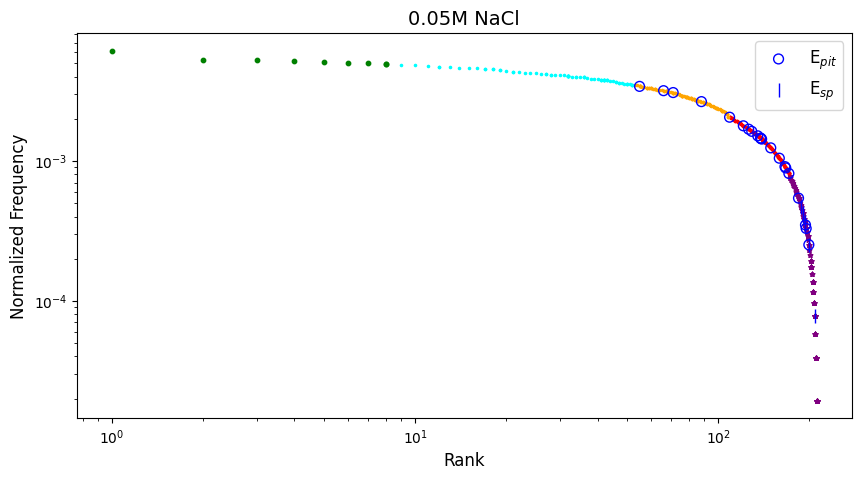

Number of Epit points: 21
Number of Esp points: 7

Distribution of Epit points across clusters:
tail's tip: 4
tail: 13
core: 4
neck: 0
head: 0

Distribution of Esp points across clusters:
tail's tip: 7
tail: 0
core: 0
neck: 0
head: 0

Epit - Median frequency: 1.451379e-03, MAD frequency: 5.611998e-04
Esp - Median frequency: 3.676826e-04, MAD frequency: 5.805515e-05


In [440]:
plt.figure(figsize=(10, 5))

# Plot each cluster in the desired order
for i, (color, marker) in enumerate(zip(colors, markers)):
    points = X[clusters == i]  # Get points belonging to this cluster using the index
    plt.scatter(points[:, 0], points[:, 1], color=color, marker=marker, s=10)

# Add highlighted Epit points
highlighted_points_Epit = X[ipit_indices_Epit]
plt.scatter(highlighted_points_Epit[:, 0], highlighted_points_Epit[:, 1], marker='o', facecolor="none", edgecolor='blue', 
            linewidths=1, s=50, zorder=5, label='E$_{pit}$')

# Add highlighted Esp points
highlighted_points_Esp = X[ipit_indices_Esp]
plt.scatter(highlighted_points_Esp[:, 0], highlighted_points_Esp[:, 1], marker='|', c='blue', 
            linewidths=1, s=100, zorder=5, label='E$_{sp}$')

plt.xlabel('Rank', fontsize=12)
plt.ylabel('Normalized Frequency', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.title(f"{selected_concentration}", fontsize=14)

# Define labels after plotting
labels = ["tail's tip", 'tail', 'core', 'neck', 'head']

plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Calculate median and MAD of highlighted frequencies for Epit and Esp
highlighted_freqs_Epit = normalized_counts[ipit_indices_Epit]
highlighted_freqs_Esp = normalized_counts[ipit_indices_Esp]

median_freq_Epit = np.median(highlighted_freqs_Epit)
mad_freq_Epit = np.median(np.abs(highlighted_freqs_Epit - median_freq_Epit))

median_freq_Esp = np.median(highlighted_freqs_Esp)
mad_freq_Esp = np.median(np.abs(highlighted_freqs_Esp - median_freq_Esp))

print(f"Number of Epit points: {len(ipit_indices_Epit)}")
print(f"Number of Esp points: {len(ipit_indices_Esp)}")

# Calculate the distribution of Epit and Esp points across clusters
Epit_cluster_distribution = [np.sum(clusters[ipit_indices_Epit] == cluster_id) for cluster_id in range(len(labels))]
Esp_cluster_distribution = [np.sum(clusters[ipit_indices_Esp] == cluster_id) for cluster_id in range(len(labels))]

print("\nDistribution of Epit points across clusters:")
for label, count in zip(labels, Epit_cluster_distribution):
    print(f"{label}: {count}")

print("\nDistribution of Esp points across clusters:")
for label, count in zip(labels, Esp_cluster_distribution):
    print(f"{label}: {count}")

print(f"\nEpit - Median frequency: {median_freq_Epit:.6e}, MAD frequency: {mad_freq_Epit:.6e}")
print(f"Esp - Median frequency: {median_freq_Esp:.6e}, MAD frequency: {mad_freq_Esp:.6e}")

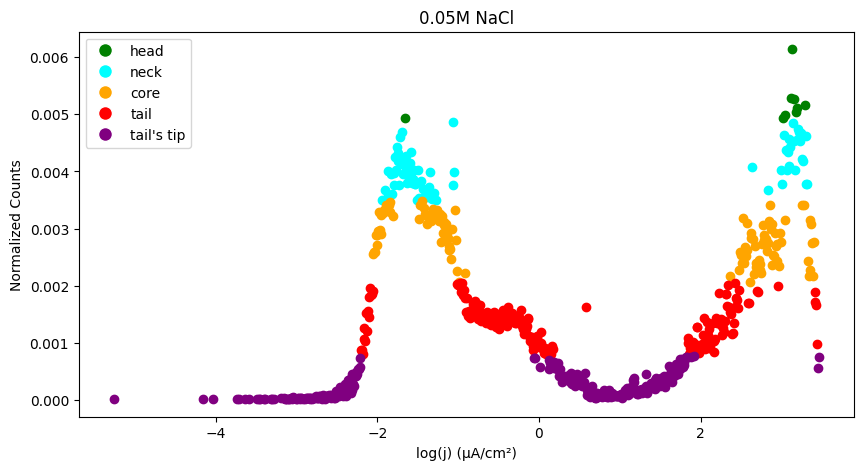

In [441]:
# Get cluster assignments for each value
# We need to map our values to their indices in values to get the right clusters
value_to_idx = {val: i for i, val in enumerate(values)}
values_indices = np.array([value_to_idx[val] for val in values])
values_clusters = clusters[values_indices]

# Plotting the histogram with clusters
plt.figure(figsize=(10, 5))

# Plot each cluster using its respective color without labeling
for cluster_id in [4, 3, 2, 1, 0]:  # Start with 'Head' and end with 'Rarest'
    # Select the points that belong to the current cluster
    cluster_mask = values_clusters == cluster_id
    cluster_points = values[cluster_mask]
    cluster_counts = normalized_counts[cluster_mask]
    
    plt.scatter(cluster_points, cluster_counts, color=colors[cluster_id])

plt.xlabel('log(j) (µA/cm²)')
plt.ylabel('Normalized Counts')
plt.title(f"{selected_concentration}")

# Define labels with the desired order for the legend
labels = ["head", "neck", "core", "tail", "tail's tip"]

# Create custom handles for the legend, ensure the order matches your desired legend order
handles = [plt.Line2D([0], [0], marker='o', color='w', label=labels[i],
                     markerfacecolor=colors[4-i], markersize=10) for i in range(5)]

# Create the legend with the custom handles
plt.legend(handles=handles)
plt.show()

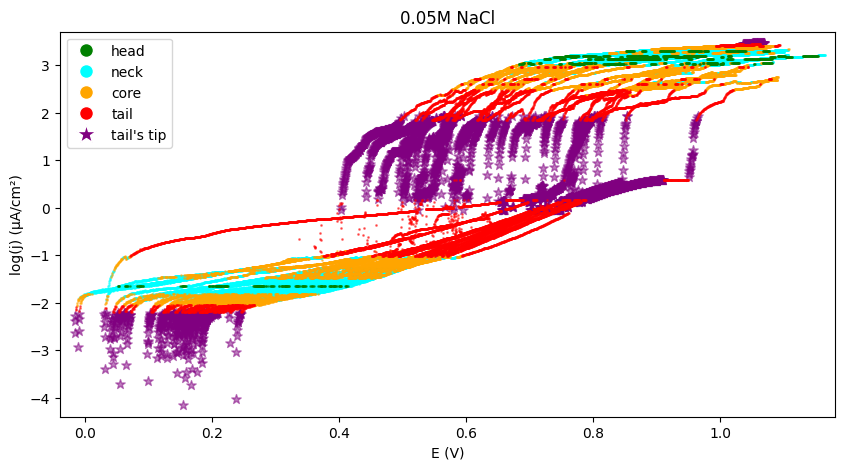

In [442]:
# Create a dictionary to map each unique value to a cluster
value_to_cluster = {val: clust for val, clust in zip(values, clusters)}

# Use this dictionary to map each data point to its cluster
data_clusters = np.array([value_to_cluster.get(val, -1) for val in valid_data])


# Plotting the scatter plot with colored points
plt.figure(figsize=(10, 5))

# First, plot the 'Tail's tip' cluster with the special marker and size
tail_tip_mask = data_clusters == 0
plt.scatter(valid_potential_data[tail_tip_mask], valid_data[tail_tip_mask], 
            color=colors[0], marker="*", s=50, alpha=0.5)

# Next, plot the other clusters except 'Head'
for cluster_id in [3, 2, 1]:  # 'Neck', 'Core', and 'Tail'
    # Select the points that belong to the current cluster
    cluster_mask = data_clusters == cluster_id
    plt.scatter(valid_potential_data[cluster_mask], valid_data[cluster_mask], 
                color=colors[cluster_id], s=1, alpha=0.5)

# Finally, plot the 'Head' cluster last so it appears on top
head_mask = data_clusters == 4
plt.scatter(valid_potential_data[head_mask], valid_data[head_mask], 
            color=colors[4], s=1, alpha=0.5)

plt.xlabel('E (V)')
plt.ylabel('log(j) (µA/cm²)')
plt.title(f"{selected_concentration}")
plt.xlim(-0.04, 1.18)
plt.ylim(-4.4, 3.7)

# Define labels with the desired order for the legend
labels = ["head", "neck", "core", "tail", "tail's tip"]

# Create custom handles for the legend, ensuring the order matches your desired legend order
# Note that the 'Tail's tip' handle uses a different marker and size
handles = [Line2D([0], [0], marker='o', color='w', label=labels[i],
                  markerfacecolor=colors[4-i], markersize=10) if i < 4 else 
           Line2D([0], [0], marker='*', color='w', label=labels[i],
                  markerfacecolor=colors[4-i], markersize=15) for i in range(len(labels))]

# Create the legend with the custom handles
plt.legend(handles=handles)
plt.show()

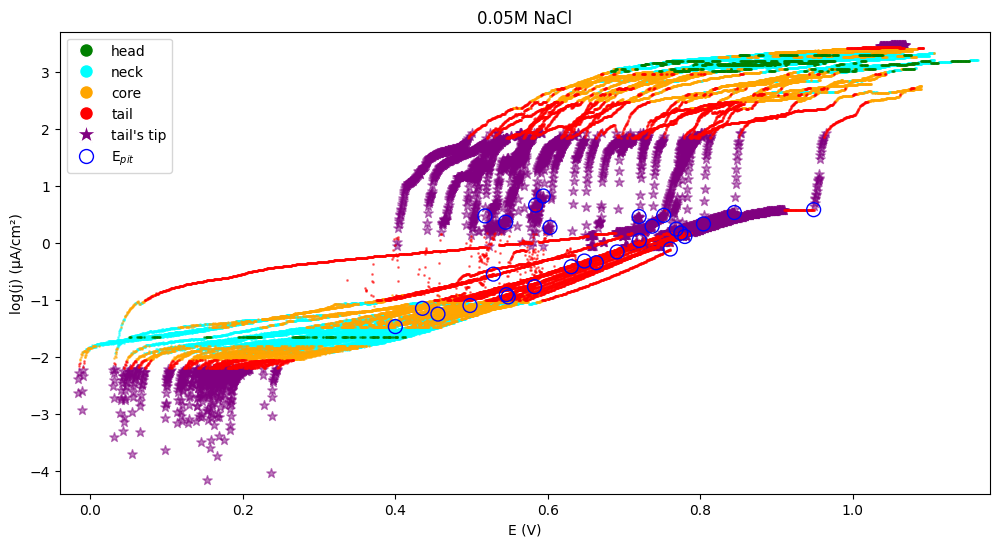

In [443]:
# Plotting the scatter plot with colored points
plt.figure(figsize=(12, 6))

# First, plot the 'Tail's tip' cluster with the special marker and size
tail_tip_mask = data_clusters == 0
plt.scatter(valid_potential_data[tail_tip_mask], valid_data[tail_tip_mask], 
            color=colors[0], marker="*", s=50, alpha=0.5)

# Next, plot the other clusters except 'Head'
for cluster_id in [3, 2, 1]:  # Start with 'Neck' and end with 'Tail'
    # Select the points that belong to the current cluster
    cluster_mask = data_clusters == cluster_id
    plt.scatter(valid_potential_data[cluster_mask], valid_data[cluster_mask], 
                color=colors[cluster_id], s=1, alpha=0.5)

# Finally, plot the 'Head' cluster last so it appears on top
head_mask = data_clusters == 4
plt.scatter(valid_potential_data[head_mask], valid_data[head_mask], 
            color=colors[4], s=1, alpha=0.5)

# Highlight the Epit points using epit_values and valid_Ipit
plt.scatter(epit_values, valid_Ipit, 
            facecolors='none', edgecolors='blue', s=100, linewidths=1, zorder=5, label='E$_{pit}$')

plt.xlabel('E (V)')
plt.ylabel('log(j) (µA/cm²)')
plt.title(f'{selected_concentration}')
plt.xlim(-0.04, 1.18)
plt.ylim(-4.4, 3.7)

# Define labels with the desired order for the legend
labels = ["head", "neck", "core", "tail", "tail's tip"]

# Create custom handles for the legend, ensuring the order matches your desired legend order
# Note that the 'Tail's tip' handle uses a different marker and size
handles = [Line2D([0], [0], marker='o', color='w', label=labels[i],
                  markerfacecolor=colors[4-i], markersize=10) if i < 4 else 
           Line2D([0], [0], marker='*', color='w', label=labels[i],
                  markerfacecolor=colors[4-i], markersize=15) for i in range(len(labels))]

# Add a handle for the Epit points (empty circle with blue edge)
handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='blue',
                     label='E$_{pit}$', markersize=10))

# Create the legend with the custom handles
plt.legend(handles=handles)

plt.show()

In [444]:
# Initialize counters and per-cluster lists
epit_tail_tip = []
ipit_tail_tip = []
epit_tail = []
ipit_tail = []

# Loop over your data (make sure epit_values, valid_Ipit, valid_potential_data, data_clusters are defined)
for epit, ipit in zip(epit_values, valid_Ipit):
    # find nearest neighbor to assign cluster
    distances = np.sqrt((valid_potential_data - epit)**2 + (valid_data - ipit)**2)
    nn_idx = np.argmin(distances)
    cluster = data_clusters[nn_idx]
    ipit_cluster_distribution[cluster] += 1

    # store per-cluster Epit & Ipit
    if cluster == 0:       # tail's tip
        epit_tail_tip.append(epit)
        ipit_tail_tip.append(ipit)
    elif cluster == 1:     # tail
        epit_tail.append(epit)
        ipit_tail.append(ipit)

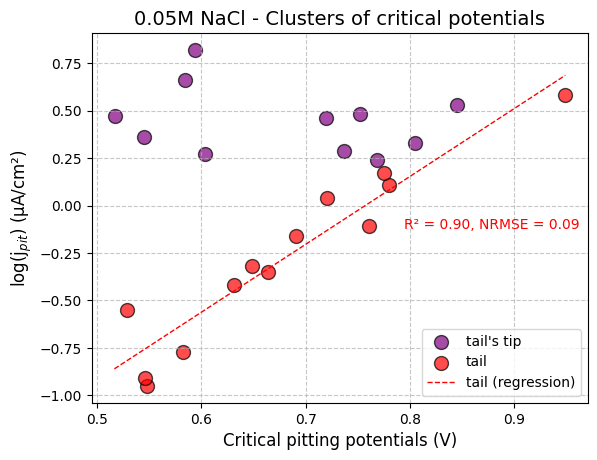

Regression statistics and metrics:
Tail's tip cluster:
  R² = 0.0785, NRMSE = 0.2793
Tail clusters:
  R² = 0.9031, NRMSE = 0.0898


In [445]:
# Import additional libraries needed for regression analysis
from sklearn.metrics import r2_score
from scipy import stats

# Function to calculate NRMSE
def nrmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse / (np.max(y_true) - np.min(y_true))

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    nrmse_val = nrmse(y_true, y_pred)
    return r2, nrmse_val

# Create the scatter plot
plt.figure()

# Scatter plot for each cluster
plt.scatter(epit_tail_tip, ipit_tail_tip, color='purple', s=100, alpha=0.7, 
            edgecolor='black', label="tail's tip")
plt.scatter(epit_tail, ipit_tail, color='red', s=100, alpha=0.7,
            edgecolor='black', label="tail")


# Regression line for tail's tip cluster
slope_tail_tip, intercept_tail_tip, r_value_tail_tip, p_value_tail_tip, std_err_tail_tip = stats.linregress(epit_tail_tip, ipit_tail_tip)
line_tail_tip = slope_tail_tip * np.array(epit_tail_tip) + intercept_tail_tip
#plt.plot(epit_tail_tip, line_tail_tip, color='purple', linestyle='-', linewidth=1, 
#         label="tail's tip (regression)")

# Prepare combined arrays (unchanged to maintain axis)
epit_core_tail = epit_core + epit_tail
ipit_core_tail = ipit_core + ipit_tail

# Perform regression using only the tail points
slope_core_tail, intercept_core_tail, r_value_core_tail, p_value_core_tail, std_err_core_tail = stats.linregress(epit_tail, ipit_tail)

# Generate a continuous range of x-values for the regression line using combined data
epit_range_core_tail = np.linspace(min(epit_core_tail), max(epit_core_tail), 100)

# Calculate the regression line using the slope and intercept from tail only
line_core_tail = slope_core_tail * epit_range_core_tail + intercept_core_tail

# Plot the continuous regression line with a dashed style
plt.plot(epit_range_core_tail, line_core_tail, color='r', linestyle='--', linewidth=1, label="tail (regression)")

# Calculate metrics for tail's tip cluster
y_pred_tail_tip = slope_tail_tip * np.array(epit_tail_tip) + intercept_tail_tip
r2_tail_tip, nrmse_tail_tip = calculate_metrics(ipit_tail_tip, y_pred_tail_tip)

# Calculate metrics for the tail-only regression line
y_pred_core_tail = slope_core_tail * np.array(epit_core_tail) + intercept_core_tail
r2_core_tail, nrmse_core_tail = calculate_metrics(ipit_core_tail, y_pred_core_tail)

#         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.63, 0.50, f"R² = {r2_core_tail:.2f}, NRMSE = {nrmse_core_tail:.2f}", c="red",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Customize the plot (unchanged)
plt.xlabel('Critical pitting potentials (V)', fontsize=12)
plt.ylabel('log(j$_{pit}$) (µA/cm²)', fontsize=12)
plt.title(f'{selected_concentration} - Clusters of critical potentials', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc="lower right")
plt.show()

# Print regression statistics and metrics
print("Regression statistics and metrics:")
print("Tail's tip cluster:")
print(f"  R² = {r2_tail_tip:.4f}, NRMSE = {nrmse_tail_tip:.4f}")
print("Tail clusters:")
print(f"  R² = {r2_core_tail:.4f}, NRMSE = {nrmse_core_tail:.4f}")

Slope for E$_{pit}$ regression line: 4.1033 log(µA/cm²)/V


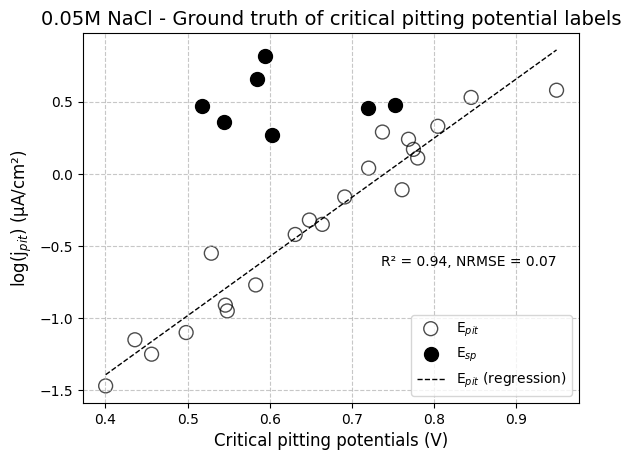

In [446]:
# Function to calculate NRMSE
def nrmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse / (np.max(y_true) - np.min(y_true))

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    nrmse_val = nrmse(y_true, y_pred)
    return r2, nrmse_val

# Create the scatter plot
plt.figure()  # Increased figure size for better visibility

# Get indices of meta points
meta_i = [i for i in range(len(epit_values1_meta)) if not np.isnan(epit_values_meta[i])]

# Get indices of all points
all_indices = list(range(len(epit_values)))

# Get indices of transparent points (all points minus meta points)
transparent_indices = [i for i in all_indices if i not in meta_i]

# Scatter plot for transparent points
transparent_epit = [epit_values[i] for i in transparent_indices]
transparent_ipit = [valid_Ipit[i] for i in transparent_indices]
plt.scatter(transparent_epit, transparent_ipit, facecolors='none', edgecolors='k', s=100, alpha=0.7, marker='o', label="E$_{pit}$")

# Scatter plot for meta points
meta_epit = [epit_values[i] for i in meta_i]
meta_ipit = [valid_Ipit[i] for i in meta_i]
plt.scatter(meta_epit, meta_ipit, color='k', s=100, marker='o', zorder=3, label="E$_{sp}$")

# Regression line for transparent points (excluding meta points)
slope_transparent, intercept_transparent, r_value_transparent, p_value_transparent, std_err_transparent = stats.linregress(transparent_epit, transparent_ipit)
epit_range_transparent = np.linspace(min(transparent_epit), max(transparent_epit), 100)
line_transparent = slope_transparent * epit_range_transparent + intercept_transparent
plt.plot(epit_range_transparent, line_transparent, color='k', linestyle='--', linewidth=1, label="E$_{pit}$ (regression)")

# Print slope (Epit regression) with units
# Since the y-axis is log(j) and x-axis is E (V), slope unit is log(µA/cm²)/V
print(f"Slope for E$_{{pit}}$ regression line: {slope_transparent:.4f} log(µA/cm²)/V")

# Calculate metrics
r2_transparent, nrmse_transparent = calculate_metrics(
    transparent_ipit, slope_transparent * np.array(transparent_epit) + intercept_transparent)

# Add R² and NRMSE values to the plot
plt.text(0.6, 0.4, f"R² = {r2_transparent:.2f}, NRMSE = {nrmse_transparent:.2f}",
         color="k", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Customize the plot
plt.xlabel('Critical pitting potentials (V)', fontsize=12)
plt.ylabel('log(j$_{pit}$) (µA/cm²)', fontsize=12)
plt.title(f'{selected_concentration} - Ground truth of critical pitting potential labels', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc="lower right")
plt.show()

Correlation coefficient: 0.9882


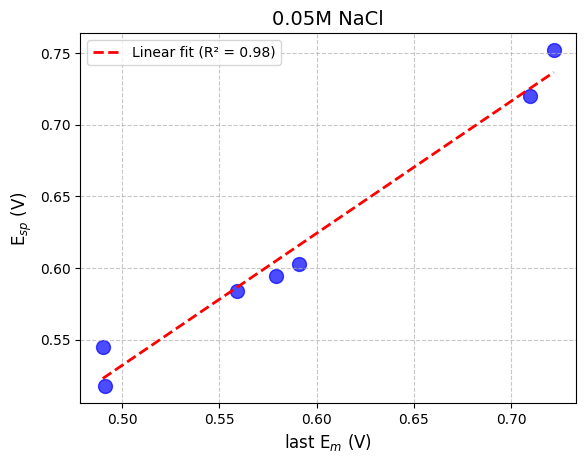

In [447]:
# Extract Epit values for 'meta' points (X-axis)
X = [epit_values_meta[i] for i in meta_i]

# Extract Epit values for 'actual Epit after meta' points (Y-axis)
Y = [epit_values[i] for i in meta_i]

# Convert lists to numpy arrays for efficient computation
X = np.array(X)
Y = np.array(Y)

# Remove any potential NaN values (should already be handled in meta_indices)
valid_indices = ~np.isnan(X) & ~np.isnan(Y)
X = X[valid_indices]
Y = Y[valid_indices]

# Create the scatter plot
plt.figure()
plt.scatter(X, Y, color='blue', s=100, alpha=0.7, marker='o')

# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(X, Y)[0, 1]
print(f"Correlation coefficient: {correlation_coefficient:.4f}")

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)

# Generate a continuous range of x-values for plotting the line
X_range = np.linspace(min(X), max(X), 100)
line = slope * X_range + intercept

# Plot the regression line with a dashed style
plt.plot(X_range, line, color='red', linestyle='--', linewidth=2, label=f"Linear fit (R² = {r_value**2:.2f})")

# Customize the plot
plt.xlabel('last E$_{m}$ (V)', fontsize=12)
plt.ylabel('E$_{sp}$ (V)', fontsize=12)
plt.title(f'{selected_concentration}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()

Central estimation for E$_{pit}$: 0.73 V
Central estimation for E$_{sp}$: 0.57 V


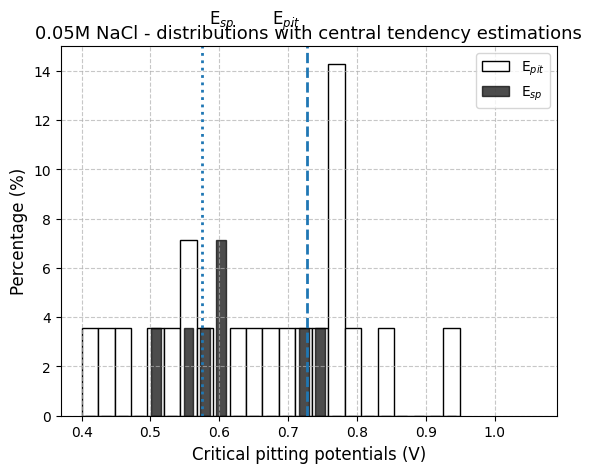

In [448]:
# Import necessary libraries
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches

# Assuming you have `transparent_epit` and `meta_epit` from your previous code
# Combine all Epit values to compute common bins
all_epit = transparent_epit + meta_epit
bins = np.linspace(min(all_epit), max(all_epit), 24)  # Adjust the number of bins as needed

# Calculate histogram data for stable points
counts_stable, _ = np.histogram(transparent_epit, bins=bins)

# Calculate histogram data for metastable points
counts_metastable, _ = np.histogram(meta_epit, bins=bins)

# Normalize counts to sum to 1
total_counts = counts_stable + counts_metastable
prob_stable = counts_stable / total_counts.sum()
prob_metastable = counts_metastable / total_counts.sum()

# Convert probabilities to percentages
percent_stable = prob_stable * 100
percent_metastable = prob_metastable * 100

# Create the histogram plot
plt.figure()

# Plot histogram for stable points (white bars)
plt.bar(bins[:-1], percent_stable, width=np.diff(bins), align='edge',
        color='white', edgecolor='black', label='E$_{pit}$', alpha=1.0)

# Plot histogram for metastable points (black bars), with narrower width
bar_width_factor = 0.6  # Adjust this factor to control how narrow the black bars are
plt.bar(bins[:-1] + (1 - bar_width_factor) * np.diff(bins) / 2,  # Shift the narrower bars
        percent_metastable, width=bar_width_factor * np.diff(bins), align='edge',
        color='black', edgecolor='black', label='E$_{sp}$', alpha=0.7)

# Calculate KDE for stable points
kde_stable = gaussian_kde(transparent_epit)
x_kde = np.linspace(min(all_epit), max(all_epit), 1000)
kde_stable_values = kde_stable(x_kde)

# Scale KDE to match histogram height
kde_stable_values_scaled = kde_stable_values * (percent_stable.max() / kde_stable_values.max())

# Calculate KDE for metastable points
kde_metastable = gaussian_kde(meta_epit)
kde_metastable_values = kde_metastable(x_kde)

# Scale KDE to match histogram height
kde_metastable_values_scaled = kde_metastable_values * (percent_metastable.max() / kde_metastable_values.max())

# Find the modes (most probable values)
mode_stable = x_kde[np.argmax(kde_stable_values)]
mode_metastable = x_kde[np.argmax(kde_metastable_values)]

# Plot vertical lines at the modes
plt.axvline(mode_stable, linestyle='--', linewidth=2)
plt.axvline(mode_metastable, linestyle='dotted', linewidth=2)

# Annotate the modes
plt.text(mode_stable-0.01, plt.ylim()[1]*1.1, f'E$_{{pit}}$', va='top', ha='right', fontsize=12)
plt.text(mode_metastable+0.01, plt.ylim()[1]*1.1, f'E$_{{sp}}$', va='top', ha='left', fontsize=12)

# Print the central estimation values instead of annotating
print(f'Central estimation for E$_{{pit}}$: {mode_stable:.2f} V')
print(f'Central estimation for E$_{{sp}}$: {mode_metastable:.2f} V')

# Customize the plot
plt.xlabel('Critical pitting potentials (V)', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title(f'{selected_concentration} - distributions with central tendency estimations', fontsize=13)
plt.ylim(0, 15)  # Adjust Y-axis limits as needed

# Create custom legend handles
stable_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='E$_{pit}$')
metastable_patch = mpatches.Patch(facecolor='black', edgecolor='black', label='E$_{sp}$', alpha=0.7)

# Add the custom legend
plt.legend(handles=[stable_patch, metastable_patch], fontsize=10, loc="upper right")

# Show the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0.37, 1.09)
plt.show()